In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyspedas
import pytplot
import datetime
from pytplot import tplot, get_data, store_data, del_data
from scipy import stats, interpolate, integrate
from astropy import units, constants
pyspedas.version()

02-Sep-25 14:45:34: pyspedas version: 1.7.20


In [2]:
# minimum variance with magnetic field time series
# B1, B2, B3 are three component
def mva_ts(B1, B2, B3):
    B1m = np.nanmean(B1)
    B2m = np.nanmean(B2)
    B3m = np.nanmean(B3)
    MagMat = np.array([[np.nanmean(B1*B1) - B1m**2, np.nanmean(B1*B2) - B1m*B2m, np.nanmean(B1*B3) - B1m*B3m],
                       [np.nanmean(B2*B1) - B2m*B1m, np.nanmean(B2*B2) - B2m**2, np.nanmean(B2*B3) - B2m*B3m],
                       [np.nanmean(B3*B1) - B3m*B1m, np.nanmean(B3*B2) - B3m*B2m, np.nanmean(B3*B3) - B3m**2]])
    vals, vecs = np.linalg.eig(MagMat)
    print(vals, vecs)
    inds = np.argsort(abs(vals))
    vn = vecs[:,inds[0]]
    vm = vecs[:,inds[1]]
    vl = vecs[:,inds[2]]
    return vl, vm, vn

# compute normal with cross product
def vnormc(B_pre, B_post):
    nc = np.cross(B_pre, B_post)
    nc = nc / np.sqrt(np.sum(nc**2))
    cth = np.dot(B_pre, B_post)/np.sqrt(np.sum(B_pre**2)*np.sum(B_post**2))
    theta = np.arccos(cth)/np.pi*180
    return nc, theta

# hybrid LMN vectors using MVA vectors and cross product normal
def hyb_lmn(vl, vm, vn, vnc):
    vnh = np.copy(vnc)
    vmh = np.cross(vnc, vl)
    vmh = vmh / np.sqrt(np.sum(vmh**2))
    vlh = np.cross(vmh, vnh)
    vlh = vlh / np.sqrt(np.sum(vlh**2))
    return vlh, vmh, vnh

# clean spike for data around 0, needs clean_spike, get_data, store_data, del_data
def my_clean_spike(dataset, nsmoot=10, thres=0.2, offset=100.0):
    data = get_data(dataset).y
    data_offset = data + offset
    dataset_offset = store_data(dataset + '-offset', data={'x': get_data(dataset).times, 'y': data_offset})
    pyspedas.clean_spikes(dataset + '-offset', nsmooth=nsmoot, thresh=thres)
    data_cleaned = get_data(dataset + '-offset-despike').y - offset
    store_data(dataset + '-clean', data={'x': get_data(dataset).times, 'y': data_cleaned})
    del_data(dataset + '-offset')
    del_data(dataset + '-offset-despike')
    return

02-Sep-25 14:45:40: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
02-Sep-25 14:45:40: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018111312_v02.cdf to psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018111312_v02.cdf
02-Sep-25 14:45:41: Download complete: psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018111312_v02.cdf
02-Sep-25 14:45:41: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
02-Sep-25 14:45:41: File is current: psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018111312_v02.cdf


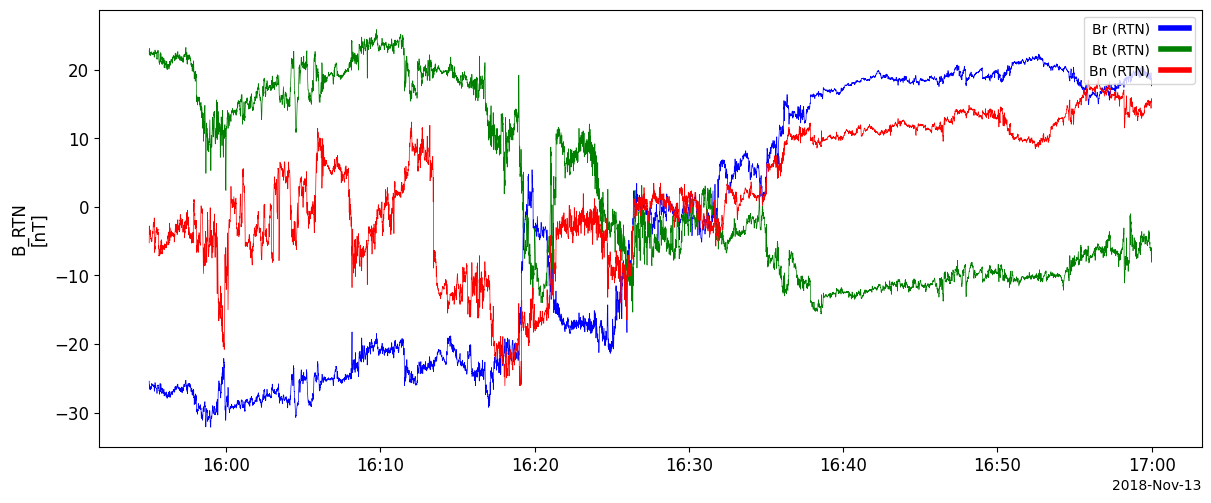

02-Sep-25 14:45:41: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2018/
02-Sep-25 14:45:41: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181113_v01.cdf to psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181113_v01.cdf


Using LEVEL=L3


02-Sep-25 14:45:41: Download complete: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181113_v01.cdf
02-Sep-25 14:45:41: Floating point data values for variable na_fit are all fillval (-1.000000e+31)
02-Sep-25 14:45:41: Floating point data values for variable na_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:45:41: Floating point data values for variable wa_fit are all fillval (-1.000000e+31)
02-Sep-25 14:45:41: Floating point data values for variable wa_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:45:41: Floating point data values for variable va_fit_SC are all fillval (-1.000000e+31)
02-Sep-25 14:45:41: Floating point data values for variable va_fit_SC_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:45:41: Floating point data values for variable va_fit_RTN are all fillval (-1.000000e+31)
02-Sep-25 14:45:41: Floating point data values for variable va_fit_RTN_uncertainty are all fillval (-1.000000e+31)


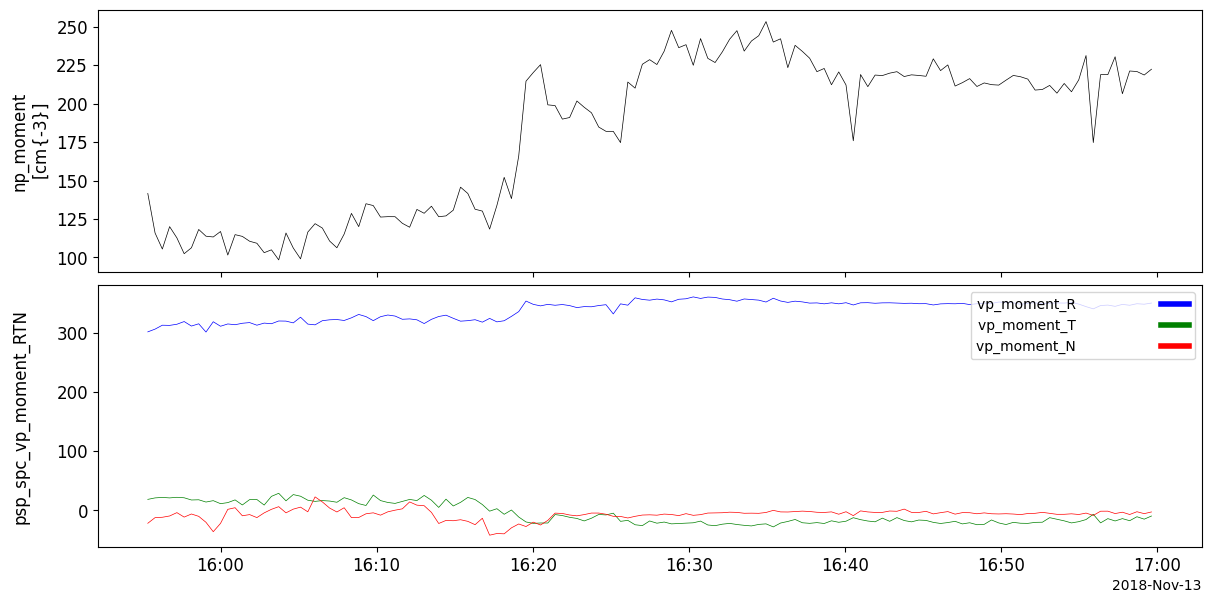

02-Sep-25 14:45:42: tsmooth was applied to: psp_spc_np_moment-despike_tmp_data-s
02-Sep-25 14:45:42: clean_spikes was applied to: psp_spc_np_moment-despike


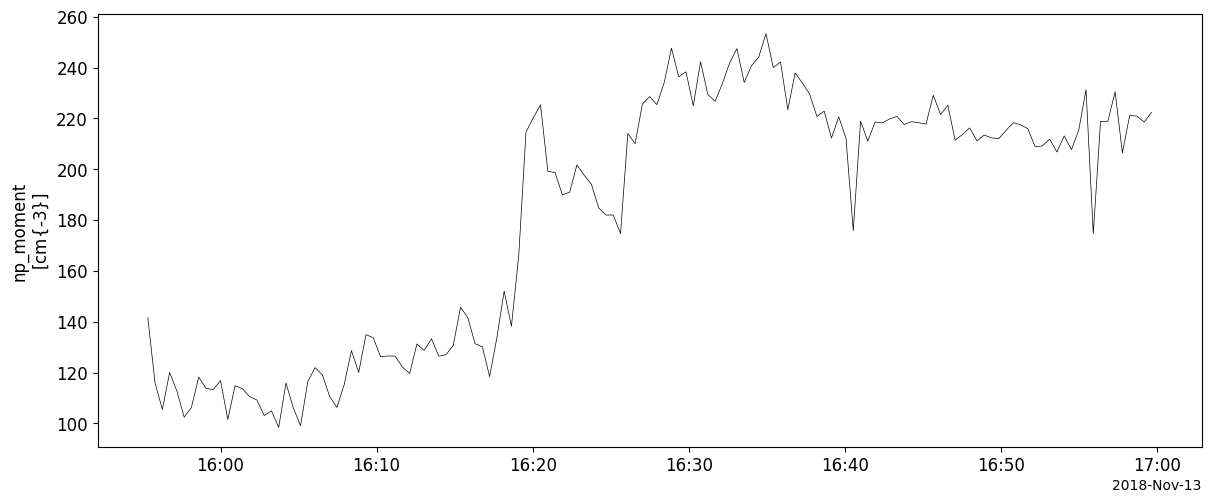

In [3]:
# PSP Event 1
Event_number = 1
starttime = "2018-11-13/15:55"
endtime = "2018-11-13/17:00"

fields_vars = pyspedas.psp.fields(trange=[starttime, endtime], datatype='mag_rtn', level='l2', time_clip=True)
tplot('psp_fld_l2_mag_RTN')
fields_datetime = pyspedas.time_datetime(get_data('psp_fld_l2_mag_RTN').times)
Br, Bt, Bn = get_data('psp_fld_l2_mag_RTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

spc_vars = pyspedas.psp.spc(trange=[starttime, endtime], datatype='l3i', level='l3', time_clip=True)
tplot(['psp_spc_np_moment', 'psp_spc_vp_moment_RTN'])

pyspedas.clean_spikes('psp_spc_np_moment', nsmooth=5)
tplot('psp_spc_np_moment-despike')
nproton_datetime = pyspedas.time_datetime(get_data('psp_spc_np_moment-despike').times)
nproton = get_data('psp_spc_np_moment-despike').y
vproton_datetime = pyspedas.time_datetime(get_data('psp_spc_vp_moment_RTN').times)
vr, vt, vn = get_data('psp_spc_vp_moment_RTN').y.T

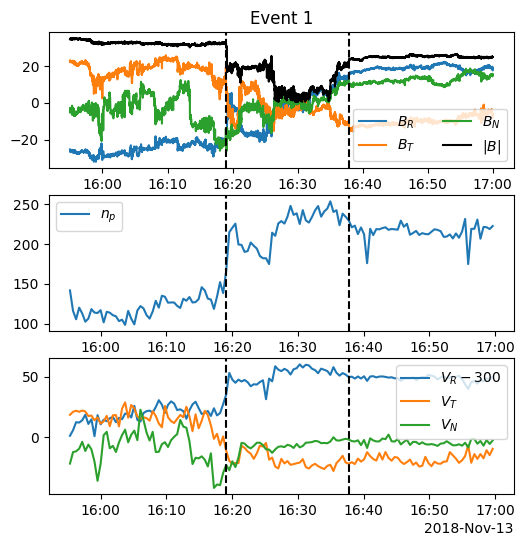

In [4]:
# HCS boundary times
B1_datetime = datetime.datetime(2018, 11, 13, 16, 19, 0)
B2_datetime = datetime.datetime(2018, 11, 13, 16, 37, 50)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-300, label=r'$V_R-300$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [5]:
# Estimate two-sided upstream averages with 20-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=20)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=20)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_fld_l2_mag_RTN_pre')
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_post1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_post')

Br1, Bt1, Bn1 = get_data('psp_fld_l2_mag_RTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = Bmag1.mean()

Br2, Bt2, Bn2 = get_data('psp_fld_l2_mag_RTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = Bmag2.mean()

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('psp_spc_np_moment-despike', dtime_pre1, dtime_pre2,
                   newname='psp_spc_np_moment_pre')
pyspedas.time_clip('psp_spc_np_moment-despike', dtime_post1, dtime_post2,
                   newname='psp_spc_np_moment_post')
npro1 = get_data('psp_spc_np_moment_pre').y
npro2 = get_data('psp_spc_np_moment_post').y
npro_av1 = npro1.mean()
npro_av2 = npro2.mean()

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_spc_vp_moment_RTN_pre')
pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_post1, dtime_post2,
                   newname='psp_spc_vp_moment_RTN_post')

Vr1, Vt1, Vn1 = get_data('psp_spc_vp_moment_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = Vr1.mean()
Vmag_av1 = Vmag1.mean()

Vr2, Vt2, Vn2 = get_data('psp_spc_vp_moment_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = Vr2.mean()
Vmag_av2 = Vmag2.mean()

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  32.144436 24.95696
n_proton (/cc):  121.35289 214.65019
V_r (km/s):  320.1358 348.63327
|V| (km/s):  321.00476 349.16818


In [6]:
# find lmn coordinates with MVA
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_mva')
Br_m, Bt_m, Bn_m = get_data('psp_fld_l2_mag_RTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)

vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

# calculate thickness with HCS velocity. Try SC frame velocity
pyspedas.time_clip('psp_spc_vp_moment_SC', dtime_pre2, dtime_post1,
                   newname='psp_spc_vp_moment_SC_inhcs')

Vx_sc_hcs, Vy_sc_hcs, Vz_sc_hcs = get_data('psp_spc_vp_moment_SC_inhcs').y.T
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = -Vz_sc_hcs, Vx_sc_hcs, -Vy_sc_hcs
Vn_sc_lmn_crossing = (Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2]).mean()
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

[542.67996368  12.9415395   58.11150486] [[ 0.80108229 -0.59809391 -0.02346994]
 [-0.51286606 -0.70608905  0.48826903]
 [ 0.30860261  0.37910674  0.87237751]]
[[ 0.79751438 -0.51745833  0.31017365]
 [ 0.10150503 -0.39170993 -0.91447256]
 [ 0.5946995   0.76078916 -0.25986966]] 156.9459992015206
Vn (km/s): -135.0; width (km): -152496.4
Vn (km/s): 129.9; width (km): 146802.9


Text(0, 0.5, 'km/s')

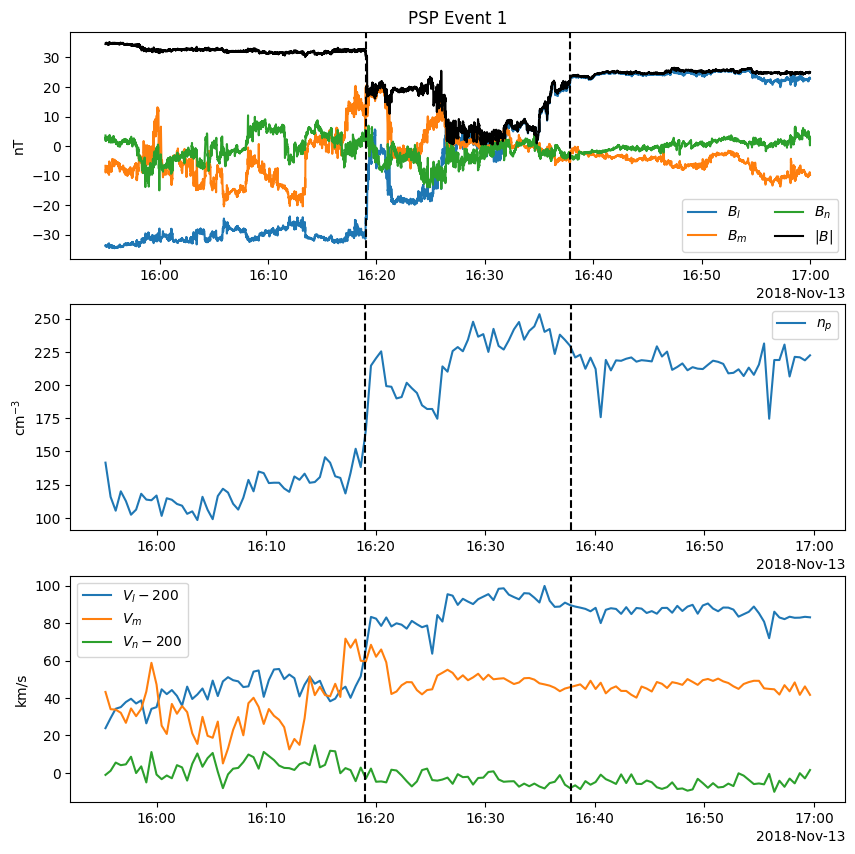

In [7]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("PSP Event %d" %(Event_number))
# plt.axvline(pyspedas.time_double("2018-11-13T16:19:00"))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')
axs[0].set_ylabel("nT")

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')
axs[1].set_ylabel(r"cm$^{-3}$")

axs[2].plot(nproton_datetime, vl_lmn-200, label=r'$V_l-200$')
axs[2].plot(nproton_datetime, vm_lmn, label=r'$V_m$')
axs[2].plot(nproton_datetime, vn_lmn-200, label=r'$V_n-200$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/P%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

02-Sep-25 14:46:38: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
02-Sep-25 14:46:38: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018112312_v02.cdf to psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018112312_v02.cdf
02-Sep-25 14:46:38: Download complete: psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018112312_v02.cdf
02-Sep-25 14:46:38: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018112318_v02.cdf to psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018112318_v02.cdf
02-Sep-25 14:46:39: Download complete: psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018112318_v02.cdf
02-Sep-25 14:46:39: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
02-Sep-25 14:46:39: File is current: psp_data/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_2018112312_v02.cdf
02-Sep-25 14:46:39: File is current: psp_da

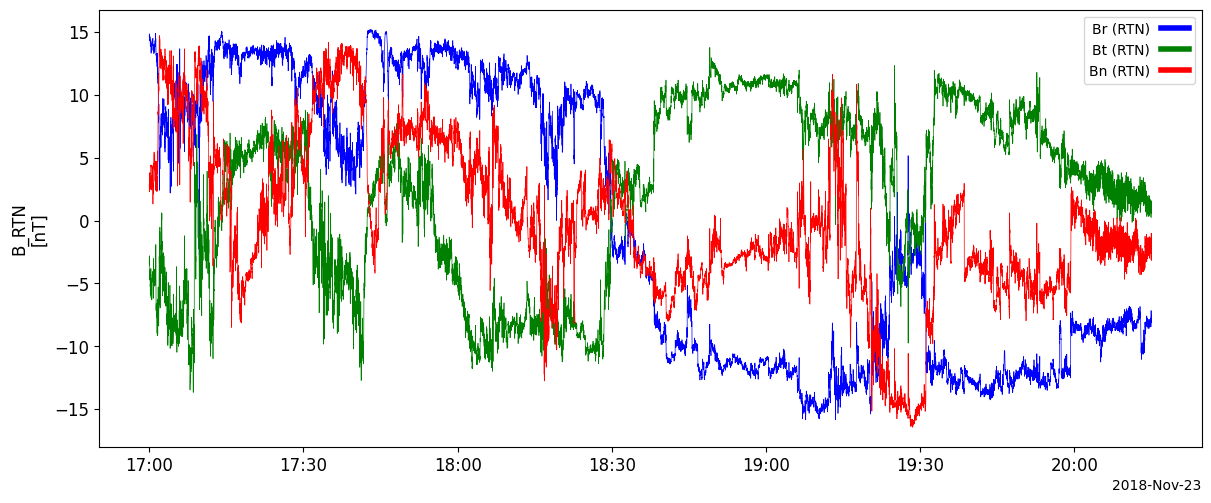

02-Sep-25 14:46:39: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2018/
02-Sep-25 14:46:39: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181123_v01.cdf to psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181123_v01.cdf


Using LEVEL=L3


02-Sep-25 14:46:40: Download complete: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181123_v01.cdf
02-Sep-25 14:46:40: Floating point data values for variable na_fit are all fillval (-1.000000e+31)
02-Sep-25 14:46:40: Floating point data values for variable na_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:46:40: Floating point data values for variable wa_fit are all fillval (-1.000000e+31)
02-Sep-25 14:46:40: Floating point data values for variable wa_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:46:40: Floating point data values for variable va_fit_SC are all fillval (-1.000000e+31)
02-Sep-25 14:46:40: Floating point data values for variable va_fit_SC_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:46:40: Floating point data values for variable va_fit_RTN are all fillval (-1.000000e+31)
02-Sep-25 14:46:40: Floating point data values for variable va_fit_RTN_uncertainty are all fillval (-1.000000e+31)


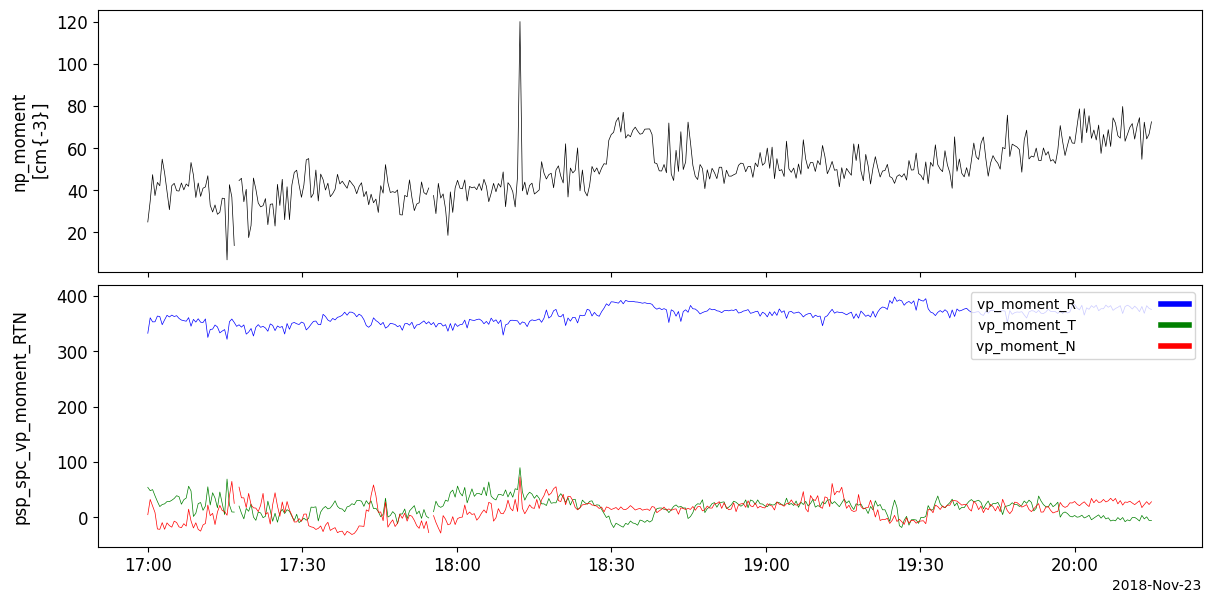

In [8]:
# PSP Event 2
Event_number = 2
starttime = "2018-11-23/17:00"
endtime = "2018-11-23/20:15"

fields_vars = pyspedas.psp.fields(trange=[starttime, endtime], datatype='mag_rtn', level='l2', time_clip=True)
tplot('psp_fld_l2_mag_RTN')
fields_datetime = pyspedas.time_datetime(get_data('psp_fld_l2_mag_RTN').times)
Br, Bt, Bn = get_data('psp_fld_l2_mag_RTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

spc_vars = pyspedas.psp.spc(trange=[starttime, endtime], datatype='l3i', level='l3', time_clip=True)
tplot(['psp_spc_np_moment', 'psp_spc_vp_moment_RTN'])
nproton_datetime = pyspedas.time_datetime(get_data('psp_spc_np_moment').times)
nproton = get_data('psp_spc_np_moment').y
vproton_datetime = pyspedas.time_datetime(get_data('psp_spc_vp_moment_RTN').times)
vr, vt, vn = get_data('psp_spc_vp_moment_RTN').y.T

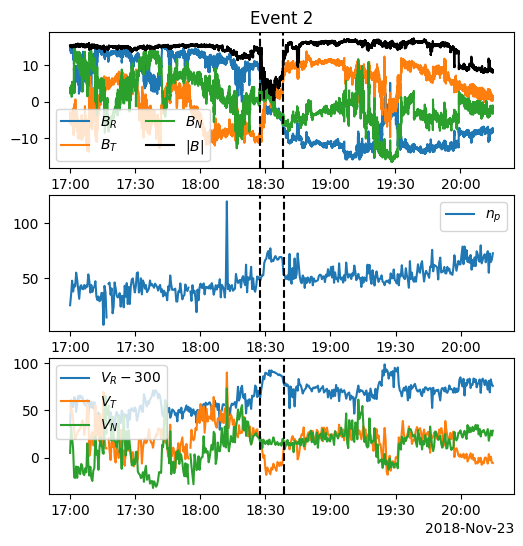

In [9]:
# HCS boundary times
B1_datetime = datetime.datetime(2018, 11, 23, 18, 27, 46)
B2_datetime = datetime.datetime(2018, 11, 23, 18, 38, 26)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-300, label=r'$V_R-300$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [10]:
# Estimate two-sided upstream averages with 40-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=40)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=40)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_fld_l2_mag_RTN_pre')
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_post1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_post')

Br1, Bt1, Bn1 = get_data('psp_fld_l2_mag_RTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('psp_fld_l2_mag_RTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.mean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('psp_spc_np_moment', dtime_pre1, dtime_pre2,
                   newname='psp_spc_np_moment_pre')
pyspedas.time_clip('psp_spc_np_moment', dtime_post1, dtime_post2,
                   newname='psp_spc_np_moment_post')
npro1 = get_data('psp_spc_np_moment_pre').y
npro2 = get_data('psp_spc_np_moment_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_spc_vp_moment_RTN_pre')
pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_post1, dtime_post2,
                   newname='psp_spc_vp_moment_RTN_post')

Vr1, Vt1, Vn1 = get_data('psp_spc_vp_moment_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('psp_spc_vp_moment_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  14.383114 15.824245
n_proton (/cc):  42.32917 51.77218
V_r (km/s):  354.66827 370.05408
|V| (km/s):  357.19778 371.64478


In [11]:
# find lmn coordinates with MVA
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_mva')
Br_m, Bt_m, Bn_m = get_data('psp_fld_l2_mag_RTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)

vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

# calculate thickness with HCS velocity. Try SC frame velocity
pyspedas.time_clip('psp_spc_vp_moment_SC', dtime_pre2, dtime_post1,
                   newname='psp_spc_vp_moment_SC_inhcs')

Vx_sc_hcs, Vy_sc_hcs, Vz_sc_hcs = get_data('psp_spc_vp_moment_SC_inhcs').y.T
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = -Vz_sc_hcs, Vx_sc_hcs, -Vy_sc_hcs
Vn_sc_lmn_crossing = (Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2]).mean()
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

[177.74572162   6.69996664  19.4622261 ] [[ 0.80865638 -0.5314903   0.25217638]
 [-0.55844741 -0.55876194  0.61312445]
 [ 0.18496313  0.63663424  0.74865578]]
[[ 0.81207052 -0.55733265  0.17297913]
 [ 0.5184697   0.82511021  0.22446002]
 [-0.26782575 -0.09259293  0.9590078 ]] 167.79306360355287
Vn (km/s): -155.6; width (km): -99569.1
Vn (km/s): -72.4; width (km): -46367.0


Text(0, 0.5, 'km/s')

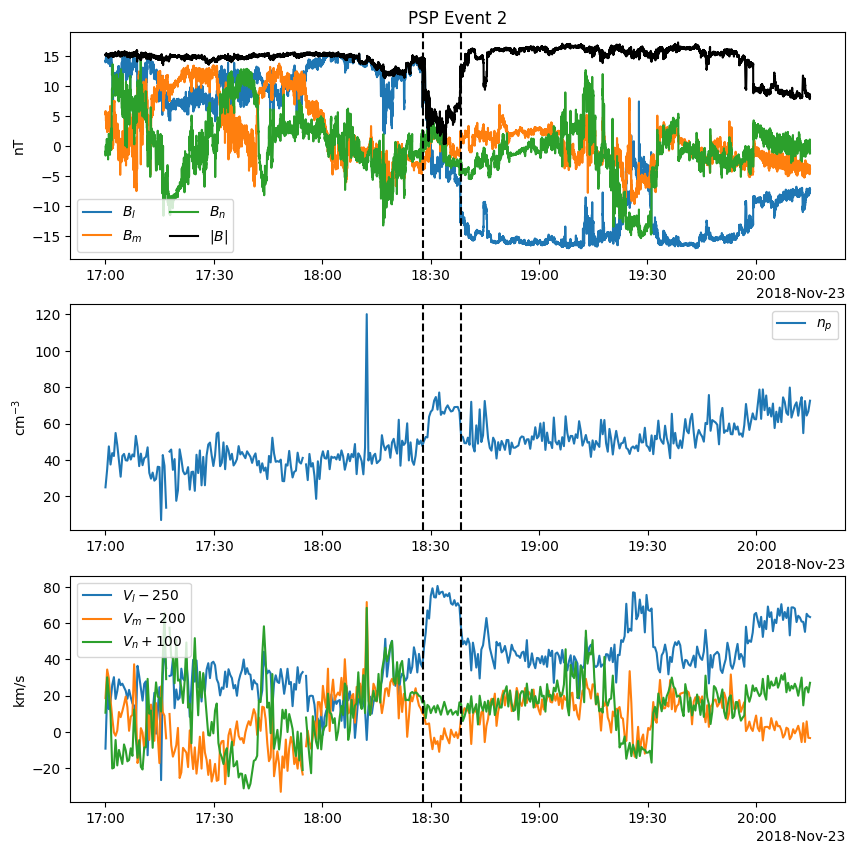

In [12]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("PSP Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vl_lmn-250, label=r'$V_l-250$')
axs[2].plot(nproton_datetime, vm_lmn-200, label=r'$V_m-200$')
axs[2].plot(nproton_datetime, vn_lmn+100, label=r'$V_n+100$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

axs[0].set_ylabel("nT")
axs[1].set_ylabel(r"cm$^{-3}$")
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/P%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

02-Sep-25 14:47:01: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/
02-Sep-25 14:47:01: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020012000_v02.cdf to psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020012000_v02.cdf
02-Sep-25 14:47:09: Download complete: psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020012000_v02.cdf
02-Sep-25 14:47:10: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/
02-Sep-25 14:47:10: File is current: psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020012000_v02.cdf


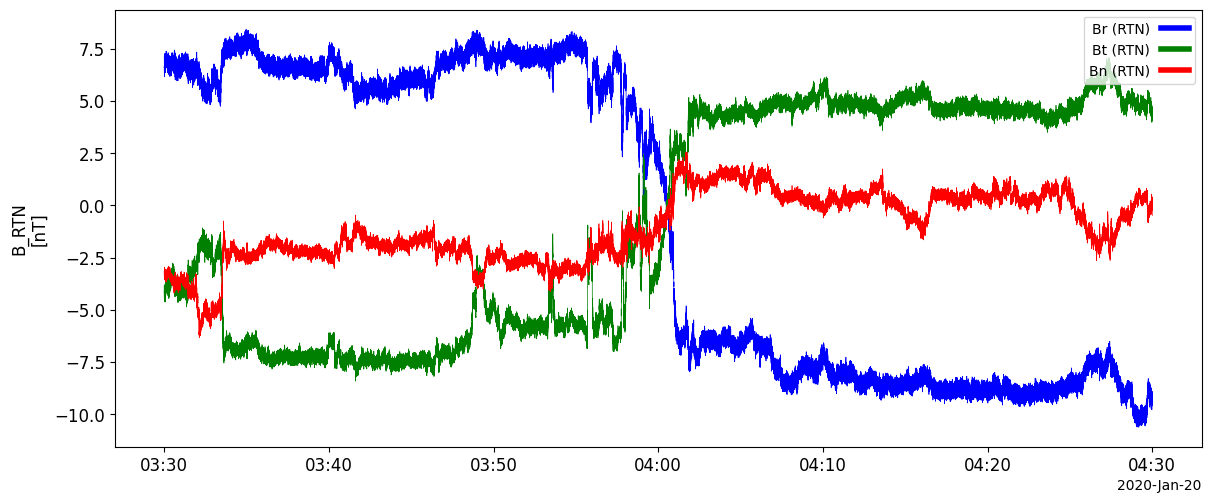

02-Sep-25 14:47:10: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/
02-Sep-25 14:47:11: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200120_v02.cdf to psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200120_v02.cdf


Using LEVEL=L3


02-Sep-25 14:47:16: Download complete: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200120_v02.cdf
02-Sep-25 14:47:16: Floating point data values for variable na_fit are all fillval (-1.000000e+31)
02-Sep-25 14:47:16: Floating point data values for variable na_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:47:16: Floating point data values for variable wa_fit are all fillval (-1.000000e+31)
02-Sep-25 14:47:16: Floating point data values for variable wa_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:47:16: Floating point data values for variable va_fit_SC are all fillval (-1.000000e+31)
02-Sep-25 14:47:16: Floating point data values for variable va_fit_SC_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:47:16: Floating point data values for variable va_fit_RTN are all fillval (-1.000000e+31)
02-Sep-25 14:47:16: Floating point data values for variable va_fit_RTN_uncertainty are all fillval (-1.000000e+31)


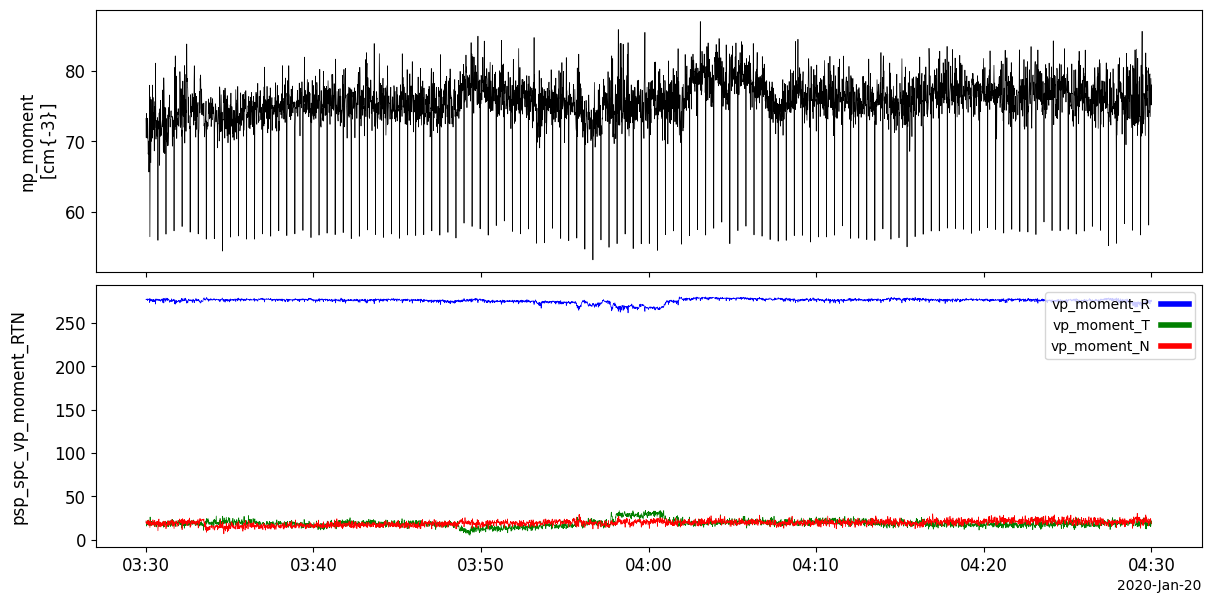

02-Sep-25 14:47:17: tsmooth was applied to: psp_spc_np_moment-despike_tmp_data-s
02-Sep-25 14:47:17: clean_spikes was applied to: psp_spc_np_moment-despike


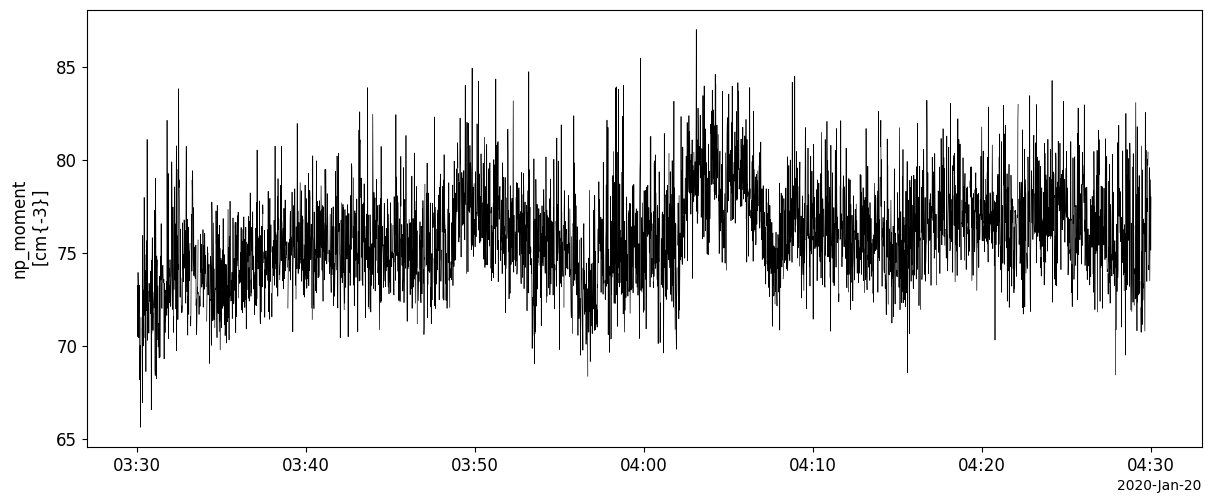

In [13]:
# PSP Event 3
Event_number = 3
starttime = "2020-1-20/3:30"
endtime = "2020-1-20/4:30"

fields_vars = pyspedas.psp.fields(trange=[starttime, endtime], datatype='mag_rtn', level='l2', time_clip=True)
tplot('psp_fld_l2_mag_RTN')
fields_datetime = pyspedas.time_datetime(get_data('psp_fld_l2_mag_RTN').times)
Br, Bt, Bn = get_data('psp_fld_l2_mag_RTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

spc_vars = pyspedas.psp.spc(trange=[starttime, endtime], datatype='l3i', level='l3', time_clip=True)
tplot(['psp_spc_np_moment', 'psp_spc_vp_moment_RTN'])
vproton_datetime = pyspedas.time_datetime(get_data('psp_spc_vp_moment_RTN').times)
vr, vt, vn = get_data('psp_spc_vp_moment_RTN').y.T

pyspedas.clean_spikes('psp_spc_np_moment', nsmooth=5, thresh=0.1)
tplot('psp_spc_np_moment-despike')
nproton_datetime = pyspedas.time_datetime(get_data('psp_spc_np_moment-despike').times)
nproton = get_data('psp_spc_np_moment-despike').y

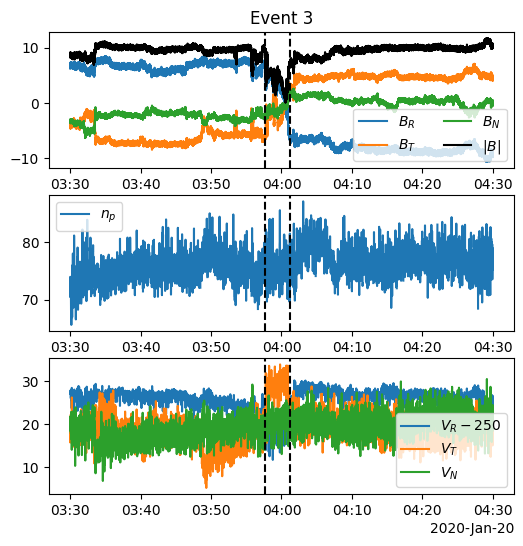

In [14]:
# HCS boundary times
B1_datetime = datetime.datetime(2020, 1, 20, 3, 57, 38)
B2_datetime = datetime.datetime(2020, 1, 20, 4, 1, 15)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-250, label=r'$V_R-250$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [15]:
# Estimate two-sided upstream averages with 20-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=20)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=20)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_fld_l2_mag_RTN_pre')
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_post1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_post')

Br1, Bt1, Bn1 = get_data('psp_fld_l2_mag_RTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('psp_fld_l2_mag_RTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.mean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('psp_spc_np_moment-despike', dtime_pre1, dtime_pre2,
                   newname='psp_spc_np_moment_pre')
pyspedas.time_clip('psp_spc_np_moment-despike', dtime_post1, dtime_post2,
                   newname='psp_spc_np_moment_post')
npro1 = get_data('psp_spc_np_moment_pre').y
npro2 = get_data('psp_spc_np_moment_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_spc_vp_moment_RTN_pre')
pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_post1, dtime_post2,
                   newname='psp_spc_vp_moment_RTN_post')

Vr1, Vt1, Vn1 = get_data('psp_spc_vp_moment_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('psp_spc_vp_moment_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  9.578279 9.241747
n_proton (/cc):  75.603424 76.90388
V_r (km/s):  275.41534 277.13748
|V| (km/s):  276.5554 278.5715


In [16]:
# find lmn coordinates with MVA
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_mva')
Br_m, Bt_m, Bn_m = get_data('psp_fld_l2_mag_RTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)

vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

# calculate thickness with HCS velocity. Try SC frame velocity
pyspedas.time_clip('psp_spc_vp_moment_SC', dtime_pre2, dtime_post1,
                   newname='psp_spc_vp_moment_SC_inhcs')

Vx_sc_hcs, Vy_sc_hcs, Vz_sc_hcs = get_data('psp_spc_vp_moment_SC_inhcs').y.T
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = -Vz_sc_hcs, Vx_sc_hcs, -Vy_sc_hcs
Vn_sc_lmn_crossing = (Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2]).mean()
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

[80.58628494  1.06542067  0.35799358] [[-0.78737467  0.52255132  0.32707987]
 [ 0.59744632  0.77761662  0.19588337]
 [ 0.15198363 -0.34964627  0.92447199]]
[[-0.78730386  0.59758944  0.15178766]
 [ 0.54920668  0.56782165  0.6131481 ]
 [ 0.28022251  0.56609666 -0.77524829]] 163.25952554195692
Vn (km/s): 85.3; width (km): 18507.7
Vn (km/s): 112.7; width (km): 24456.6


Text(0, 0.5, 'km/s')

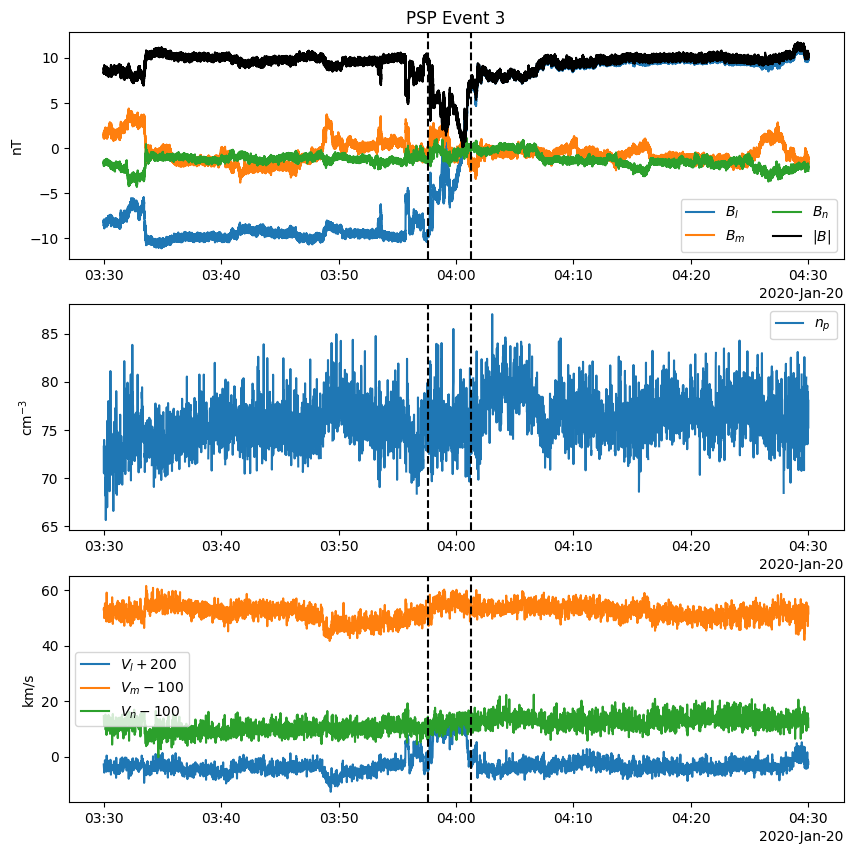

In [17]:
# plot in lmn coordinates, use MVA for this event
Bl_lmn = Br*vecl0[0] + Bt*vecl0[1] + Bn*vecl0[2]
Bm_lmn = Br*vecm0[0] + Bt*vecm0[1] + Bn*vecm0[2]
Bn_lmn = Br*vecn0[0] + Bt*vecn0[1] + Bn*vecn0[2]
vl_lmn = vr*vecl0[0] + vt*vecl0[1] + vn*vecl0[2]
vm_lmn = vr*vecm0[0] + vt*vecm0[1] + vn*vecm0[2]
vn_lmn = vr*vecn0[0] + vt*vecn0[1] + vn*vecn0[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("PSP Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vl_lmn+200, label=r'$V_l+200$')
axs[2].plot(nproton_datetime, vm_lmn-100, label=r'$V_m-100$')
axs[2].plot(nproton_datetime, vn_lmn-100, label=r'$V_n-100$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

axs[0].set_ylabel("nT")
axs[1].set_ylabel(r"cm$^{-3}$")
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/P%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

02-Sep-25 14:52:59: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/
02-Sep-25 14:53:00: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020020100_v02.cdf to psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020020100_v02.cdf
02-Sep-25 14:53:08: Download complete: psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020020100_v02.cdf
02-Sep-25 14:53:09: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/
02-Sep-25 14:53:09: File is current: psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020020100_v02.cdf


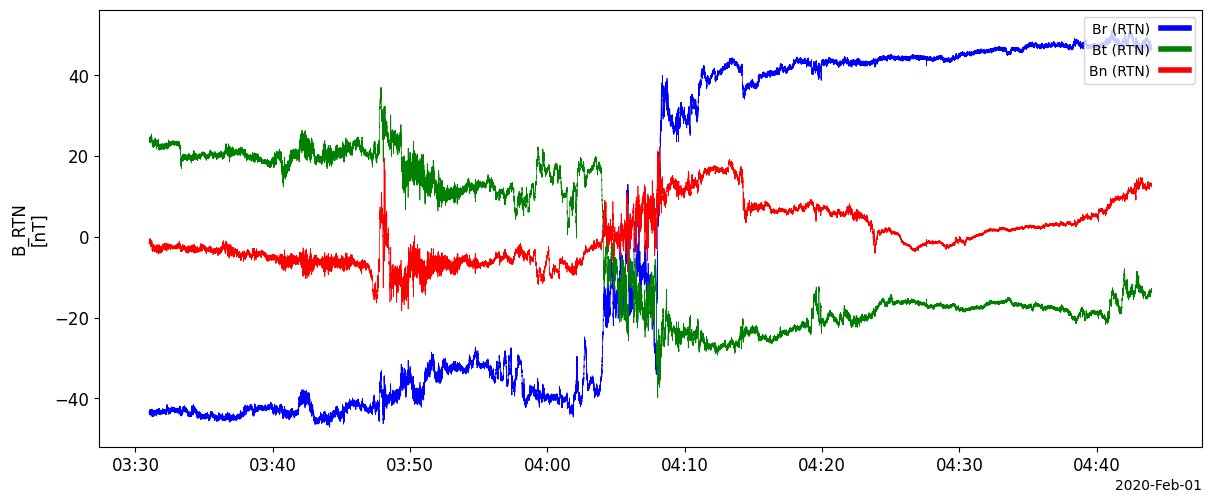

02-Sep-25 14:53:09: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/
02-Sep-25 14:53:09: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200201_v02.cdf to psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200201_v02.cdf


Using LEVEL=L3


02-Sep-25 14:53:17: Download complete: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200201_v02.cdf
02-Sep-25 14:53:17: Floating point data values for variable na_fit are all fillval (-1.000000e+31)
02-Sep-25 14:53:17: Floating point data values for variable na_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:53:17: Floating point data values for variable wa_fit are all fillval (-1.000000e+31)
02-Sep-25 14:53:17: Floating point data values for variable wa_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:53:17: Floating point data values for variable va_fit_SC are all fillval (-1.000000e+31)
02-Sep-25 14:53:17: Floating point data values for variable va_fit_SC_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:53:17: Floating point data values for variable va_fit_RTN are all fillval (-1.000000e+31)
02-Sep-25 14:53:17: Floating point data values for variable va_fit_RTN_uncertainty are all fillval (-1.000000e+31)


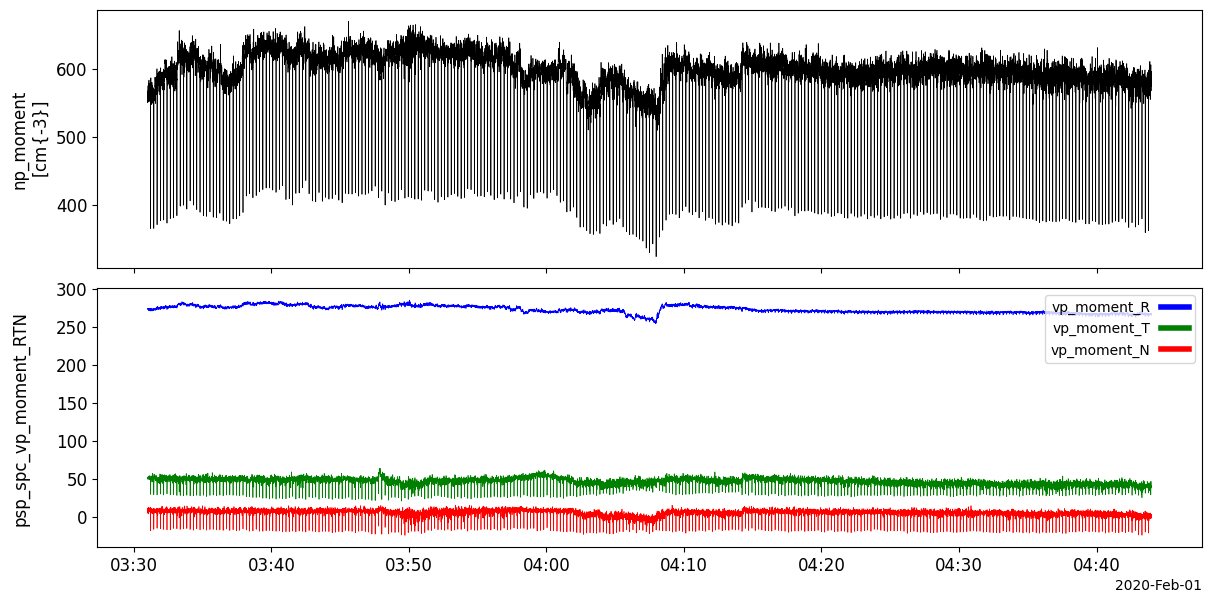

02-Sep-25 14:53:19: tsmooth was applied to: psp_spc_np_moment-despike_tmp_data-s
02-Sep-25 14:53:19: clean_spikes was applied to: psp_spc_np_moment-despike


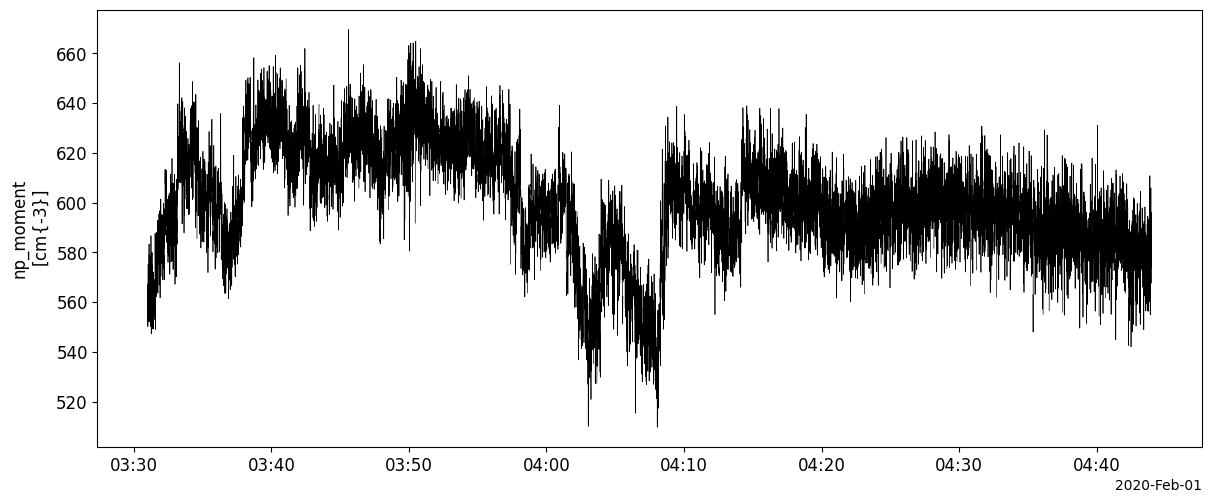

02-Sep-25 14:53:20: tsmooth was applied to: psp_spc_vp_moment_RTN-offset-despike_tmp_data-s
02-Sep-25 14:53:20: clean_spikes was applied to: psp_spc_vp_moment_RTN-offset-despike


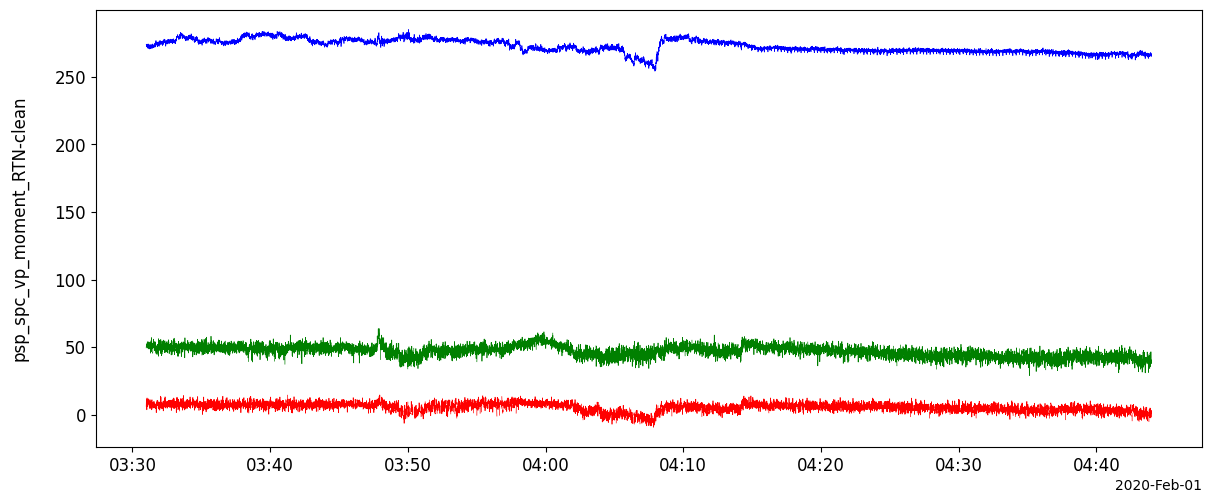

In [18]:
# PSP Event 4
Event_number = 4
starttime = "2020-2-1/03:31"
endtime = "2020-2-1/04:44"

fields_vars = pyspedas.psp.fields(trange=[starttime, endtime], datatype='mag_rtn', level='l2', time_clip=True)
tplot('psp_fld_l2_mag_RTN')
fields_datetime = pyspedas.time_datetime(get_data('psp_fld_l2_mag_RTN').times)
Br, Bt, Bn = get_data('psp_fld_l2_mag_RTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

spc_vars = pyspedas.psp.spc(trange=[starttime, endtime], datatype='l3i', level='l3', time_clip=True)
tplot(['psp_spc_np_moment', 'psp_spc_vp_moment_RTN'])

pyspedas.clean_spikes('psp_spc_np_moment', nsmooth=5, thresh=0.1)
tplot('psp_spc_np_moment-despike')
nproton_datetime = pyspedas.time_datetime(get_data('psp_spc_np_moment-despike').times)
nproton = get_data('psp_spc_np_moment-despike').y

my_clean_spike('psp_spc_vp_moment_RTN', nsmoot=10, thres=0.10, offset=50.0)
tplot('psp_spc_vp_moment_RTN-clean')
vproton_datetime = pyspedas.time_datetime(get_data('psp_spc_vp_moment_RTN-clean').times)
vr, vt, vn = get_data('psp_spc_vp_moment_RTN-clean').y.T

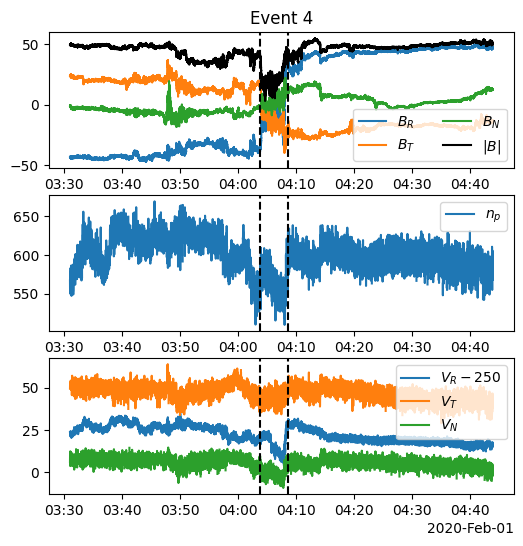

In [19]:
# HCS boundary times
B1_datetime = datetime.datetime(2020, 2, 1, 4, 3, 46)
B2_datetime = datetime.datetime(2020, 2, 1, 4, 8, 36)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-250, label=r'$V_R-250$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [20]:
# Estimate two-sided upstream averages with 30-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=30)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=30)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_fld_l2_mag_RTN_pre')
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_post1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_post')

Br1, Bt1, Bn1 = get_data('psp_fld_l2_mag_RTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('psp_fld_l2_mag_RTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.mean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('psp_spc_np_moment-despike', dtime_pre1, dtime_pre2,
                   newname='psp_spc_np_moment_pre')
pyspedas.time_clip('psp_spc_np_moment-despike', dtime_post1, dtime_post2,
                   newname='psp_spc_np_moment_post')
npro1 = get_data('psp_spc_np_moment_pre').y
npro2 = get_data('psp_spc_np_moment_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_spc_vp_moment_RTN_pre')
pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_post1, dtime_post2,
                   newname='psp_spc_vp_moment_RTN_post')

Vr1, Vt1, Vn1 = get_data('psp_spc_vp_moment_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('psp_spc_vp_moment_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  43.55392 47.985443
n_proton (/cc):  612.2778 596.85254
V_r (km/s):  276.0264 270.90198
|V| (km/s):  280.35098 274.8172


In [21]:
# find lmn coordinates with MVA
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_mva')
Br_m, Bt_m, Bn_m = get_data('psp_fld_l2_mag_RTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)

vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

# calculate thickness with HCS velocity. Try SC frame velocity
pyspedas.time_clip('psp_spc_vp_moment_SC', dtime_pre2, dtime_post1,
                   newname='psp_spc_vp_moment_SC_inhcs')

Vx_sc_hcs, Vy_sc_hcs, Vz_sc_hcs = get_data('psp_spc_vp_moment_SC_inhcs').y.T
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = -Vz_sc_hcs, Vx_sc_hcs, -Vy_sc_hcs
Vn_sc_lmn_crossing = (Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2]).mean()
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

[1945.99799271   44.28317138   11.99937112] [[-0.90445463  0.4059002   0.13117489]
 [ 0.40978889  0.74136901  0.5314556 ]
 [-0.11846894 -0.53443148  0.83686803]]
[[-0.90358811  0.41119759 -0.12018768]
 [-0.22531694 -0.69476527 -0.68303257]
 [-0.36436358 -0.59009981  0.72043145]] 177.62718363091557
Vn (km/s): 6.3; width (km): 1813.8
Vn (km/s): -61.1; width (km): -17728.5


Text(0, 0.5, 'km/s')

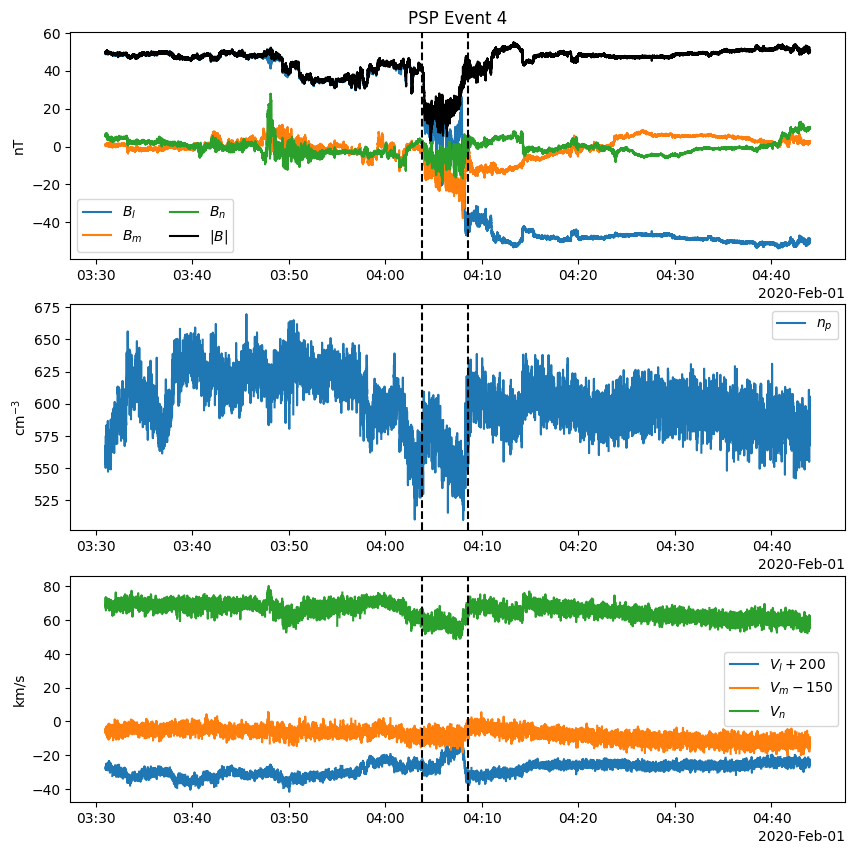

In [22]:
# plot in lmn coordinates, use MVA for this event
Bl_lmn = Br*vecl0[0] + Bt*vecl0[1] + Bn*vecl0[2]
Bm_lmn = Br*vecm0[0] + Bt*vecm0[1] + Bn*vecm0[2]
Bn_lmn = Br*vecn0[0] + Bt*vecn0[1] + Bn*vecn0[2]
vl_lmn = vr*vecl0[0] + vt*vecl0[1] + vn*vecl0[2]
vm_lmn = vr*vecm0[0] + vt*vecm0[1] + vn*vecm0[2]
vn_lmn = vr*vecn0[0] + vt*vecn0[1] + vn*vecn0[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("PSP Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vl_lmn+200, label=r'$V_l+200$')
axs[2].plot(nproton_datetime, vm_lmn-150, label=r'$V_m-150$')
axs[2].plot(nproton_datetime, vn_lmn, label=r'$V_n$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

axs[0].set_ylabel("nT")
axs[1].set_ylabel(r"cm$^{-3}$")
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/P%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

02-Sep-25 14:54:07: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/
02-Sep-25 14:54:08: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020060806_v02.cdf to psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020060806_v02.cdf
02-Sep-25 14:54:36: Download complete: psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020060806_v02.cdf
02-Sep-25 14:54:39: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/
02-Sep-25 14:54:39: File is current: psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020060806_v02.cdf


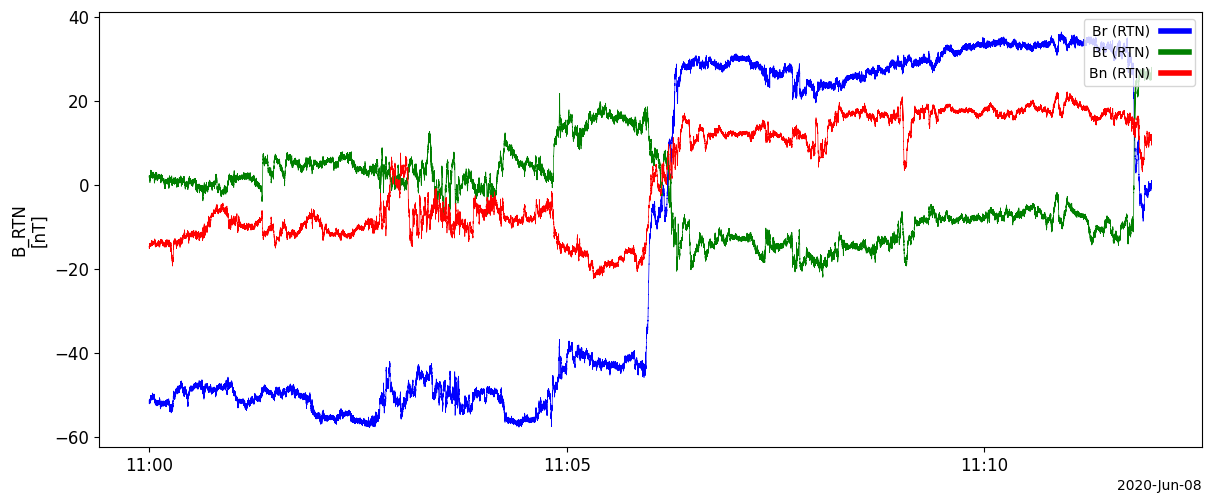

02-Sep-25 14:54:40: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/
02-Sep-25 14:54:40: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf to psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf


Using LEVEL=L3


02-Sep-25 14:54:46: Download complete: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
02-Sep-25 14:54:46: Floating point data values for variable na_fit are all fillval (-1.000000e+31)
02-Sep-25 14:54:46: Floating point data values for variable na_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:54:46: Floating point data values for variable wa_fit are all fillval (-1.000000e+31)
02-Sep-25 14:54:46: Floating point data values for variable wa_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:54:46: Floating point data values for variable va_fit_SC are all fillval (-1.000000e+31)
02-Sep-25 14:54:46: Floating point data values for variable va_fit_SC_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:54:46: Floating point data values for variable va_fit_RTN are all fillval (-1.000000e+31)
02-Sep-25 14:54:46: Floating point data values for variable va_fit_RTN_uncertainty are all fillval (-1.000000e+31)


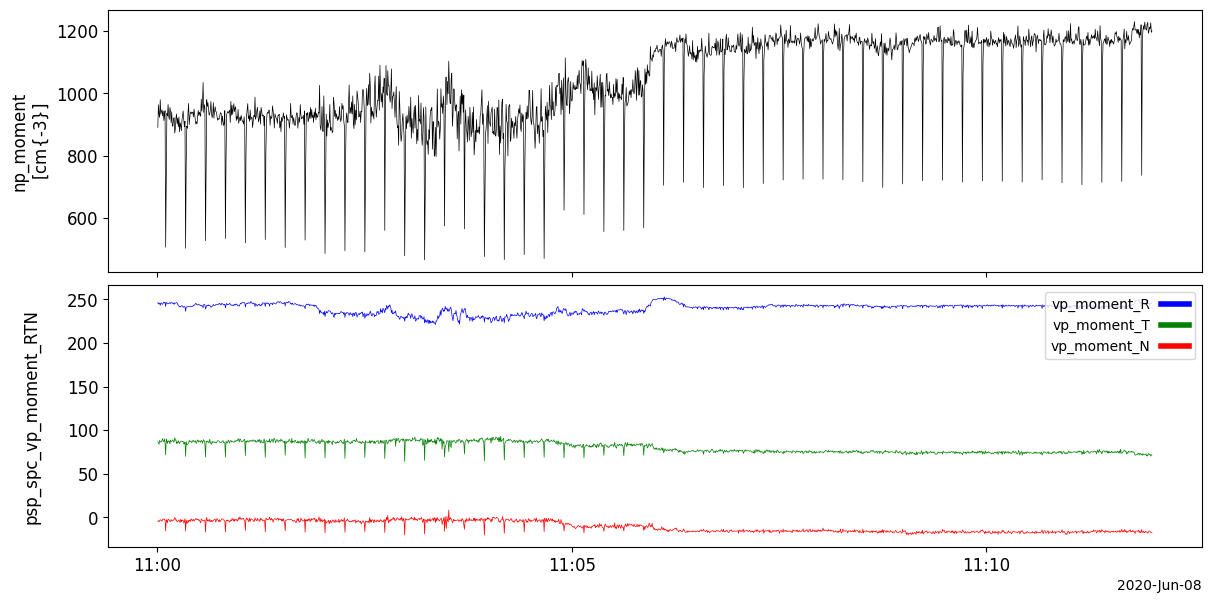

02-Sep-25 14:54:48: tsmooth was applied to: psp_spc_np_moment-despike_tmp_data-s
02-Sep-25 14:54:48: clean_spikes was applied to: psp_spc_np_moment-despike


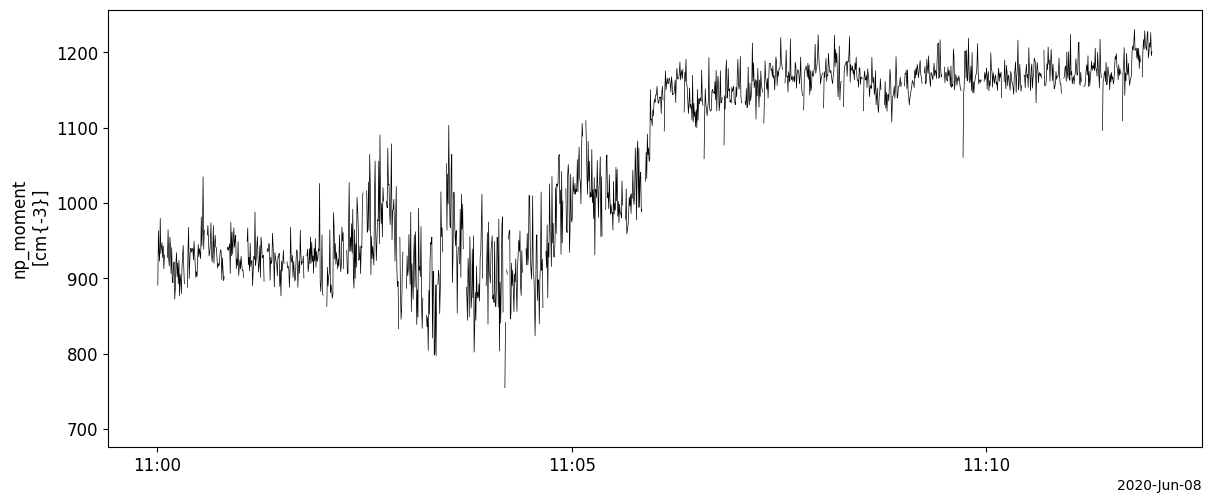

02-Sep-25 14:54:48: tsmooth was applied to: psp_spc_vp_moment_RTN-offset-despike_tmp_data-s
02-Sep-25 14:54:48: clean_spikes was applied to: psp_spc_vp_moment_RTN-offset-despike


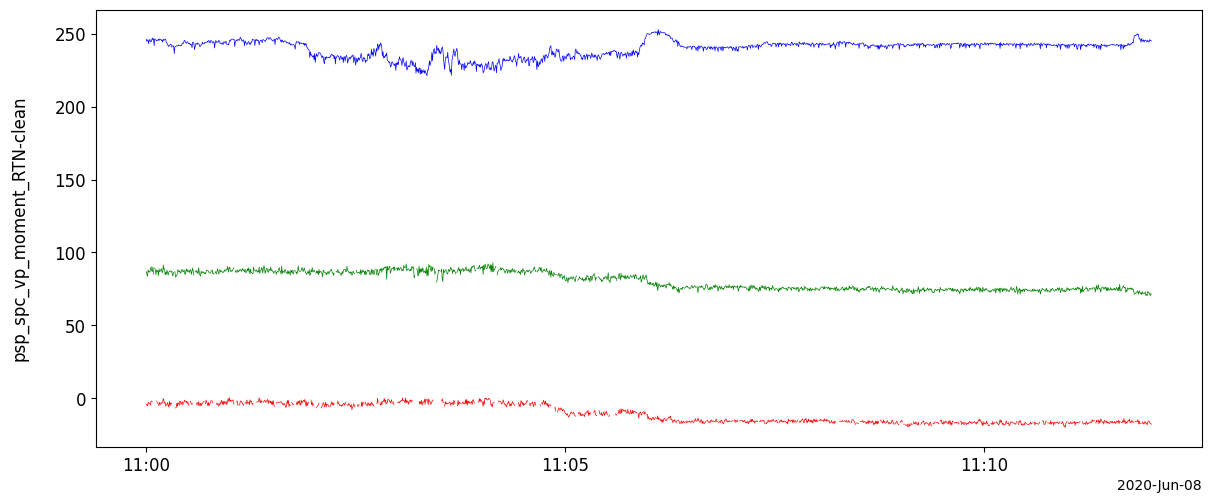

In [23]:
# PSP Event 5
Event_number = 5
starttime = "2020-6-8/11:00"
endtime = "2020-6-8/11:12"

fields_vars = pyspedas.psp.fields(trange=[starttime, endtime], datatype='mag_rtn', level='l2', time_clip=True)
tplot('psp_fld_l2_mag_RTN')
fields_datetime = pyspedas.time_datetime(get_data('psp_fld_l2_mag_RTN').times)
Br, Bt, Bn = get_data('psp_fld_l2_mag_RTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

spc_vars = pyspedas.psp.spc(trange=[starttime, endtime], datatype='l3i', level='l3', time_clip=True)
tplot(['psp_spc_np_moment', 'psp_spc_vp_moment_RTN'])
nproton_datetime = pyspedas.time_datetime(get_data('psp_spc_np_moment').times)
nproton = get_data('psp_spc_np_moment').y
vproton_datetime = pyspedas.time_datetime(get_data('psp_spc_vp_moment_RTN').times)
vr, vt, vn = get_data('psp_spc_vp_moment_RTN').y.T

pyspedas.clean_spikes('psp_spc_np_moment', nsmooth=5, thresh=0.1)
tplot('psp_spc_np_moment-despike')
nproton_datetime = pyspedas.time_datetime(get_data('psp_spc_np_moment-despike').times)
nproton = get_data('psp_spc_np_moment-despike').y

my_clean_spike('psp_spc_vp_moment_RTN', nsmoot=5, thres=0.05, offset=50.0)
tplot('psp_spc_vp_moment_RTN-clean')
vproton_datetime = pyspedas.time_datetime(get_data('psp_spc_vp_moment_RTN-clean').times)
vr, vt, vn = get_data('psp_spc_vp_moment_RTN-clean').y.T

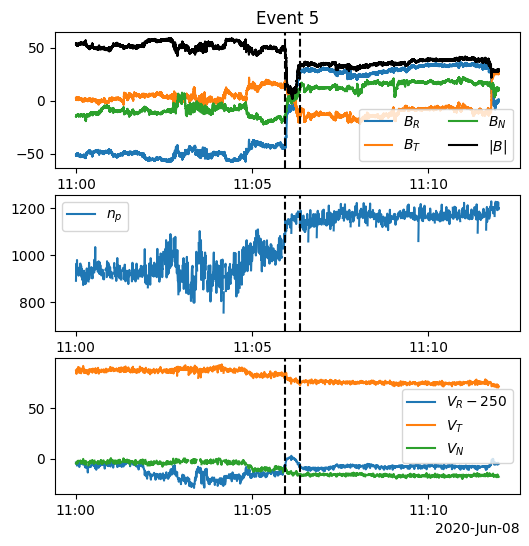

In [24]:
# HCS boundary times
B1_datetime = datetime.datetime(2020, 6, 8, 11, 5, 56)
B2_datetime = datetime.datetime(2020, 6, 8, 11, 6, 22)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-250, label=r'$V_R-250$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [25]:
# Estimate two-sided upstream averages with 5-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=5)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=5)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_fld_l2_mag_RTN_pre')
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_post1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_post')

Br1, Bt1, Bn1 = get_data('psp_fld_l2_mag_RTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('psp_fld_l2_mag_RTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.mean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('psp_spc_np_moment-despike', dtime_pre1, dtime_pre2,
                   newname='psp_spc_np_moment_pre')
pyspedas.time_clip('psp_spc_np_moment-despike', dtime_post1, dtime_post2,
                   newname='psp_spc_np_moment_post')
npro1 = get_data('psp_spc_np_moment_pre').y
npro2 = get_data('psp_spc_np_moment_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_spc_vp_moment_RTN_pre')
pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_post1, dtime_post2,
                   newname='psp_spc_vp_moment_RTN_post')

Vr1, Vt1, Vn1 = get_data('psp_spc_vp_moment_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('psp_spc_vp_moment_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  51.668037 35.562767
n_proton (/cc):  944.34796 1162.5056
V_r (km/s):  235.28091 242.11713
|V| (km/s):  250.57956 253.9681


In [26]:
# find lmn coordinates with MVA
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_mva')
Br_m, Bt_m, Bn_m = get_data('psp_fld_l2_mag_RTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)

vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

# calculate thickness with HCS velocity. Try SC frame velocity
pyspedas.time_clip('psp_spc_vp_moment_SC', dtime_pre2, dtime_post1,
                   newname='psp_spc_vp_moment_SC_inhcs')

Vx_sc_hcs, Vy_sc_hcs, Vz_sc_hcs = get_data('psp_spc_vp_moment_SC_inhcs').y.T
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = -Vz_sc_hcs, Vx_sc_hcs, -Vy_sc_hcs
Vn_sc_lmn_crossing = (Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2]).mean()
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

[1755.76786314   36.37647827   13.14595459] [[-0.9336847   0.32243316 -0.1557875 ]
 [ 0.19926826  0.82928486  0.52209079]
 [-0.2975316  -0.45642467  0.83854127]]
[[-0.93378916  0.20083934 -0.29614416]
 [-0.35448067 -0.63208791  0.68906337]
 [-0.04879811  0.74841732  0.66143054]] 160.0105001764302
Vn (km/s): -61.5; width (km): -1598.7
Vn (km/s): -40.4; width (km): -1050.3


Text(0, 0.5, 'km/s')

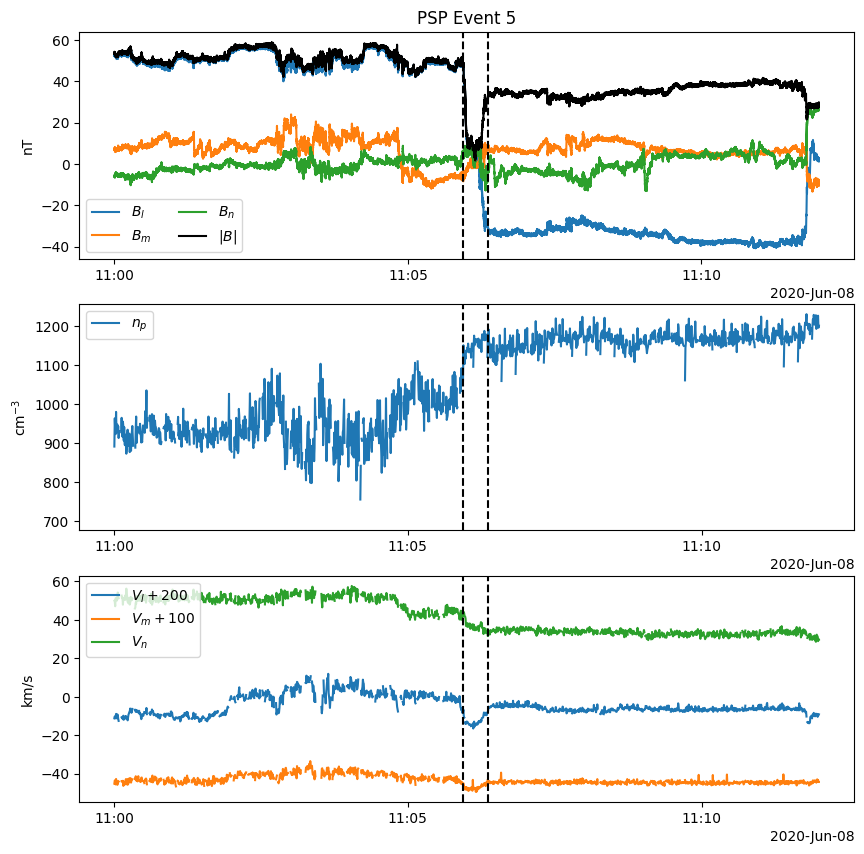

In [27]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("PSP Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vl_lmn+200, label=r'$V_l+200$')
axs[2].plot(nproton_datetime, vm_lmn+100, label=r'$V_m+100$')
axs[2].plot(nproton_datetime, vn_lmn, label=r'$V_n$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

axs[0].set_ylabel("nT")
axs[1].set_ylabel(r"cm$^{-3}$")
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/P%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

02-Sep-25 14:55:46: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/
02-Sep-25 14:55:47: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020060812_v02.cdf to psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020060812_v02.cdf
02-Sep-25 14:56:14: Download complete: psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020060812_v02.cdf
02-Sep-25 14:56:17: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2020/
02-Sep-25 14:56:18: File is current: psp_data/fields/l2/mag_rtn/2020/psp_fld_l2_mag_rtn_2020060812_v02.cdf


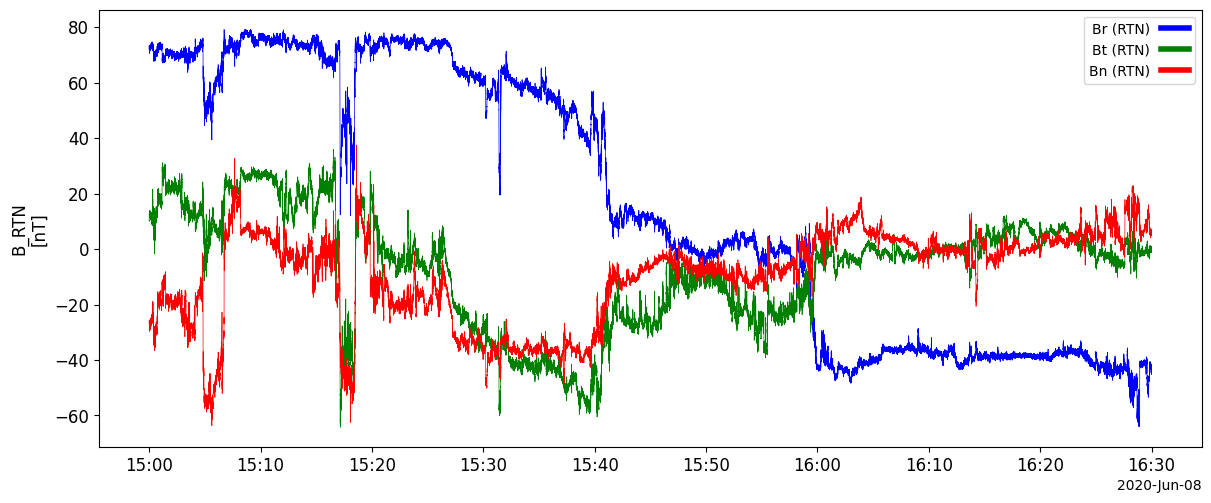

02-Sep-25 14:56:19: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/
02-Sep-25 14:56:19: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf


Using LEVEL=L3


02-Sep-25 14:56:19: Floating point data values for variable na_fit are all fillval (-1.000000e+31)
02-Sep-25 14:56:19: Floating point data values for variable na_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:56:19: Floating point data values for variable wa_fit are all fillval (-1.000000e+31)
02-Sep-25 14:56:19: Floating point data values for variable wa_fit_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:56:19: Floating point data values for variable va_fit_SC are all fillval (-1.000000e+31)
02-Sep-25 14:56:19: Floating point data values for variable va_fit_SC_uncertainty are all fillval (-1.000000e+31)
02-Sep-25 14:56:19: Floating point data values for variable va_fit_RTN are all fillval (-1.000000e+31)
02-Sep-25 14:56:19: Floating point data values for variable va_fit_RTN_uncertainty are all fillval (-1.000000e+31)


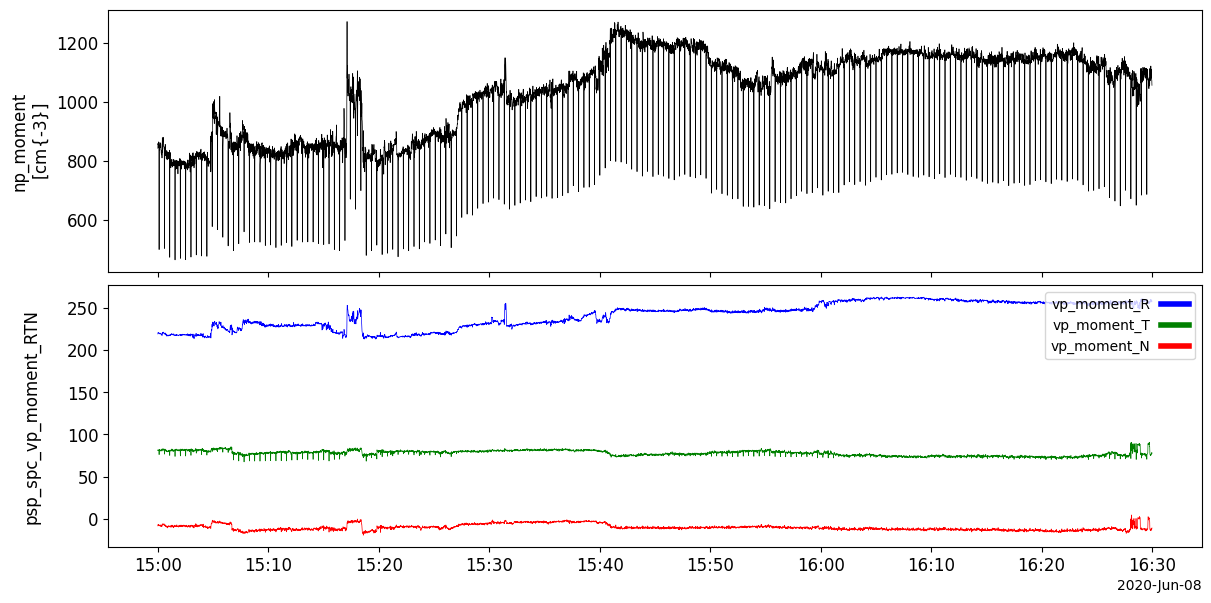

02-Sep-25 14:56:21: tsmooth was applied to: psp_spc_np_moment-despike_tmp_data-s
02-Sep-25 14:56:21: clean_spikes was applied to: psp_spc_np_moment-despike


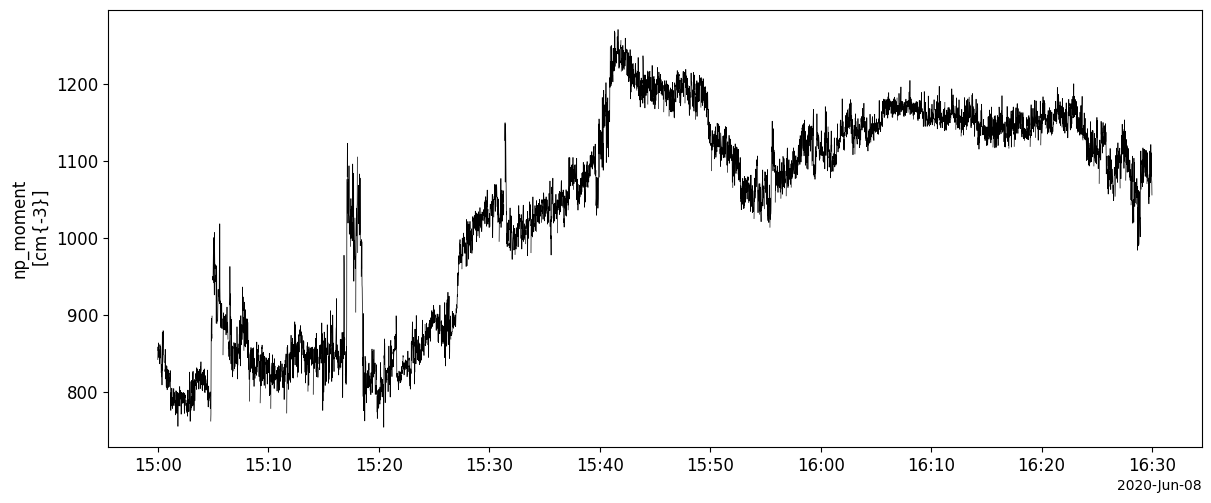

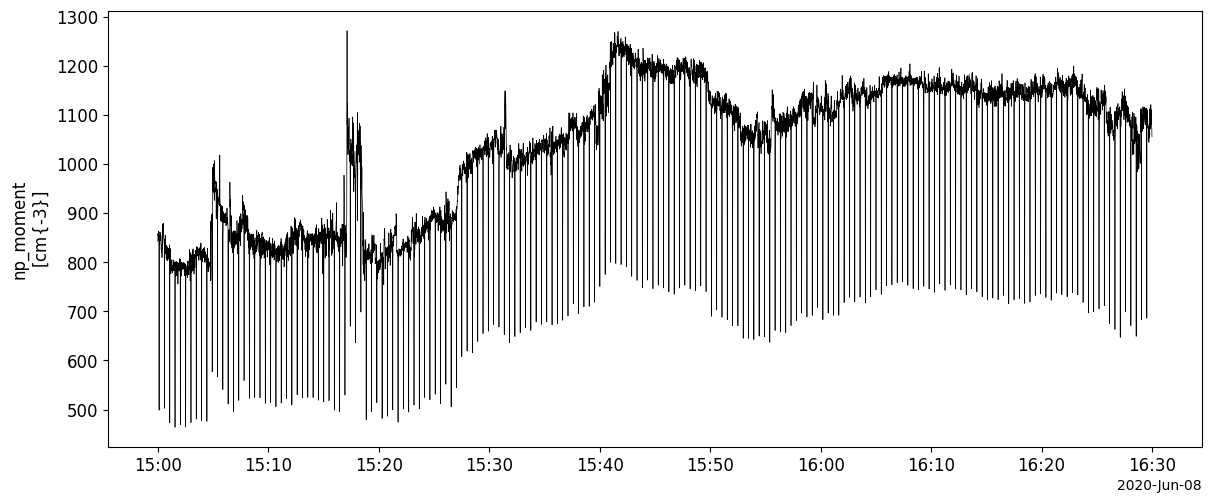

02-Sep-25 14:56:21: tsmooth was applied to: psp_spc_vp_moment_RTN-offset-despike_tmp_data-s
02-Sep-25 14:56:21: clean_spikes was applied to: psp_spc_vp_moment_RTN-offset-despike


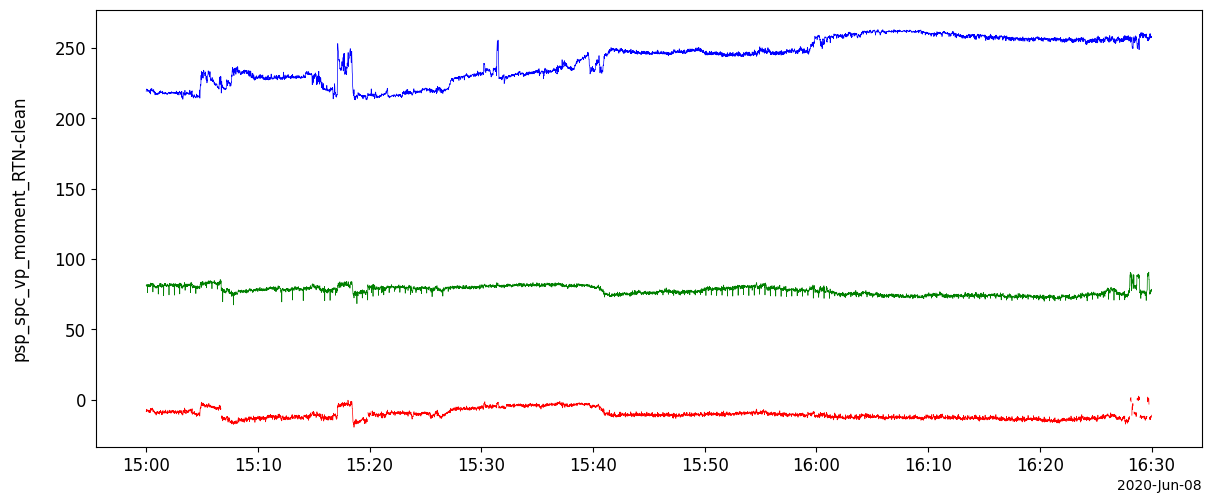

02-Sep-25 14:56:21: tsmooth was applied to: psp_spc_vp_moment_RTN-offset-despike_tmp_data-s
02-Sep-25 14:56:21: clean_spikes was applied to: psp_spc_vp_moment_RTN-offset-despike


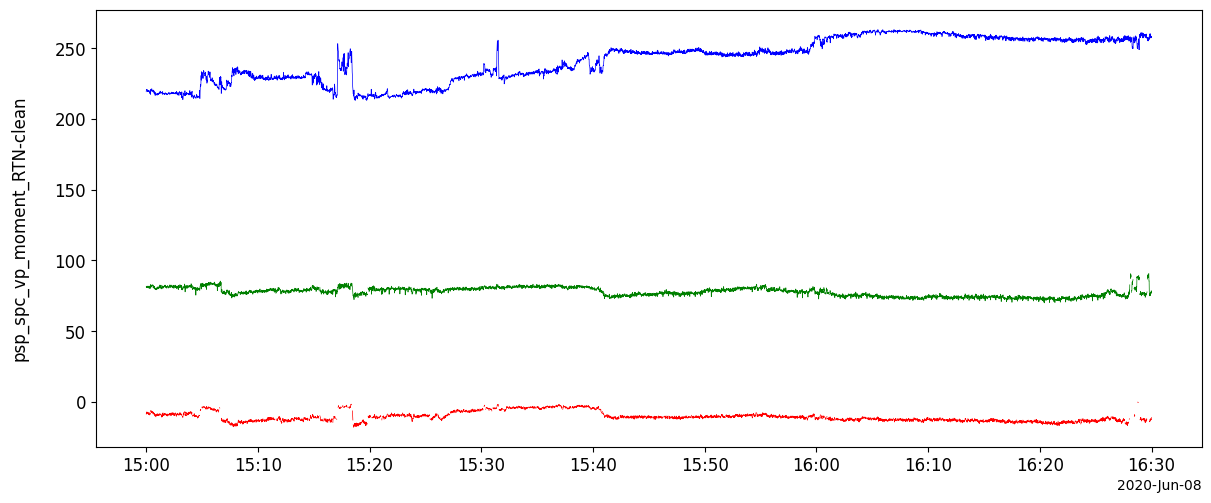

In [28]:
# PSP Event 6
Event_number = 6
starttime = "2020-6-8/15:00"
endtime = "2020-6-8/16:30"

fields_vars = pyspedas.psp.fields(trange=[starttime, endtime], datatype='mag_rtn', level='l2', time_clip=True)
tplot('psp_fld_l2_mag_RTN')
fields_datetime = pyspedas.time_datetime(get_data('psp_fld_l2_mag_RTN').times)
Br, Bt, Bn = get_data('psp_fld_l2_mag_RTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

spc_vars = pyspedas.psp.spc(trange=[starttime, endtime], datatype='l3i', level='l3', time_clip=True)
tplot(['psp_spc_np_moment', 'psp_spc_vp_moment_RTN'])
nproton_datetime = pyspedas.time_datetime(get_data('psp_spc_np_moment').times)
nproton = get_data('psp_spc_np_moment').y
vproton_datetime = pyspedas.time_datetime(get_data('psp_spc_vp_moment_RTN').times)
vr, vt, vn = get_data('psp_spc_vp_moment_RTN').y.T

pyspedas.clean_spikes('psp_spc_np_moment', nsmooth=5, thresh=0.1)
tplot('psp_spc_np_moment-despike')
tplot('psp_spc_np_moment')
nproton_datetime = pyspedas.time_datetime(get_data('psp_spc_np_moment-despike').times)
nproton = get_data('psp_spc_np_moment-despike').y

my_clean_spike('psp_spc_vp_moment_RTN', nsmoot=5, thres=0.05, offset=60.0)
tplot('psp_spc_vp_moment_RTN-clean')
vproton_datetime = pyspedas.time_datetime(get_data('psp_spc_vp_moment_RTN-clean').times)
vr, _, vn = get_data('psp_spc_vp_moment_RTN-clean').y.T

my_clean_spike('psp_spc_vp_moment_RTN', nsmoot=5, thres=0.05, offset=-10.0)
tplot('psp_spc_vp_moment_RTN-clean')
_, vt, _ = get_data('psp_spc_vp_moment_RTN-clean').y.T

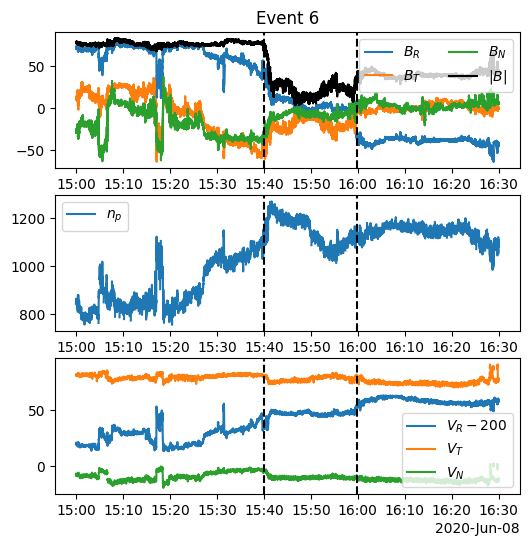

In [29]:
# HCS boundary times
B1_datetime = datetime.datetime(2020, 6, 8, 15, 40, 0)
B2_datetime = datetime.datetime(2020, 6, 8, 15, 59, 50)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2, loc='upper right')
axs[0].set_title("Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-200, label=r'$V_R-200$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend(loc='lower right')
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [30]:
# Estimate two-sided upstream averages with 10-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=10)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=10)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_fld_l2_mag_RTN_pre')
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_post1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_post')

Br1, Bt1, Bn1 = get_data('psp_fld_l2_mag_RTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('psp_fld_l2_mag_RTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.mean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('psp_spc_np_moment-despike', dtime_pre1, dtime_pre2,
                   newname='psp_spc_np_moment_pre')
pyspedas.time_clip('psp_spc_np_moment-despike', dtime_post1, dtime_post2,
                   newname='psp_spc_np_moment_post')
npro1 = get_data('psp_spc_np_moment_pre').y
npro2 = get_data('psp_spc_np_moment_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_spc_vp_moment_RTN_pre')
pyspedas.time_clip('psp_spc_vp_moment_RTN', dtime_post1, dtime_post2,
                   newname='psp_spc_vp_moment_RTN_post')

Vr1, Vt1, Vn1 = get_data('psp_spc_vp_moment_RTN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('psp_spc_vp_moment_RTN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  78.57292 40.040886
n_proton (/cc):  1044.6438 1147.3092
V_r (km/s):  234.59721 260.2064
|V| (km/s):  248.33052 271.07095


In [31]:
# find lmn coordinates with MVA
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_mva')
Br_m, Bt_m, Bn_m = get_data('psp_fld_l2_mag_RTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)

vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

# calculate thickness with HCS velocity. Try SC frame velocity
pyspedas.time_clip('psp_spc_vp_moment_SC', dtime_pre2, dtime_post1,
                   newname='psp_spc_vp_moment_SC_inhcs')

Vx_sc_hcs, Vy_sc_hcs, Vz_sc_hcs = get_data('psp_spc_vp_moment_SC_inhcs').y.T
Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = -Vz_sc_hcs, Vx_sc_hcs, -Vy_sc_hcs
Vn_sc_lmn_crossing = (Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2]).mean()
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

[1624.6515948    45.15489121   18.47391188] [[-0.84582998  0.46408745  0.26304845]
 [ 0.37161845  0.86638132 -0.33359127]
 [ 0.38271578  0.18440784  0.90527475]]
[[-0.84600901  0.3722866   0.38166928]
 [ 0.51385919  0.76024128  0.39746941]
 [-0.14218821  0.53238696 -0.83447385]] 135.59828393178077
Vn (km/s): 54.6; width (km): 65012.4
Vn (km/s): -33.6; width (km): -39934.2


Text(0, 0.5, 'km/s')

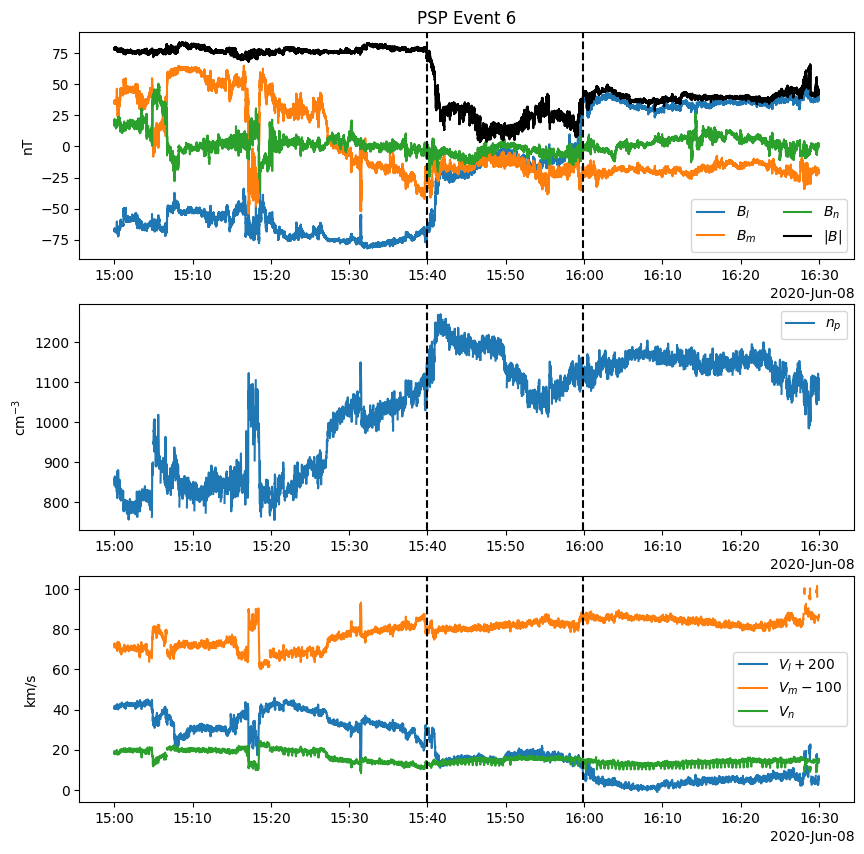

In [32]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("PSP Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vl_lmn+200, label=r'$V_l+200$')
axs[2].plot(nproton_datetime, vm_lmn-100, label=r'$V_m-100$')
axs[2].plot(nproton_datetime, vn_lmn, label=r'$V_n$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

axs[0].set_ylabel("nT")
axs[1].set_ylabel(r"cm$^{-3}$")
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/P%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

02-Sep-25 14:58:01: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2021/
02-Sep-25 14:58:01: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2021/psp_fld_l2_mag_rtn_2021011712_v02.cdf to psp_data/fields/l2/mag_rtn/2021/psp_fld_l2_mag_rtn_2021011712_v02.cdf
02-Sep-25 14:58:28: Download complete: psp_data/fields/l2/mag_rtn/2021/psp_fld_l2_mag_rtn_2021011712_v02.cdf
02-Sep-25 14:58:31: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2021/
02-Sep-25 14:58:31: File is current: psp_data/fields/l2/mag_rtn/2021/psp_fld_l2_mag_rtn_2021011712_v02.cdf


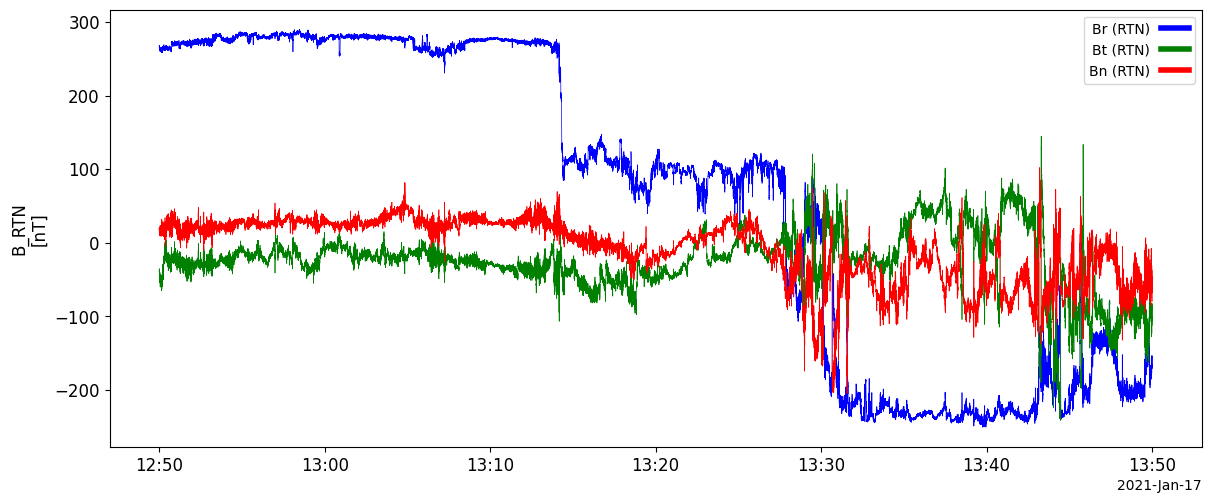

02-Sep-25 14:58:32: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2021/
02-Sep-25 14:58:32: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2021/psp_swp_spi_sf00_l3_mom_20210117_v04.cdf to psp_data/sweap/spi/l3/spi_sf00_l3_mom/2021/psp_swp_spi_sf00_l3_mom_20210117_v04.cdf


Using LEVEL=L3


02-Sep-25 14:58:35: Download complete: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2021/psp_swp_spi_sf00_l3_mom_20210117_v04.cdf


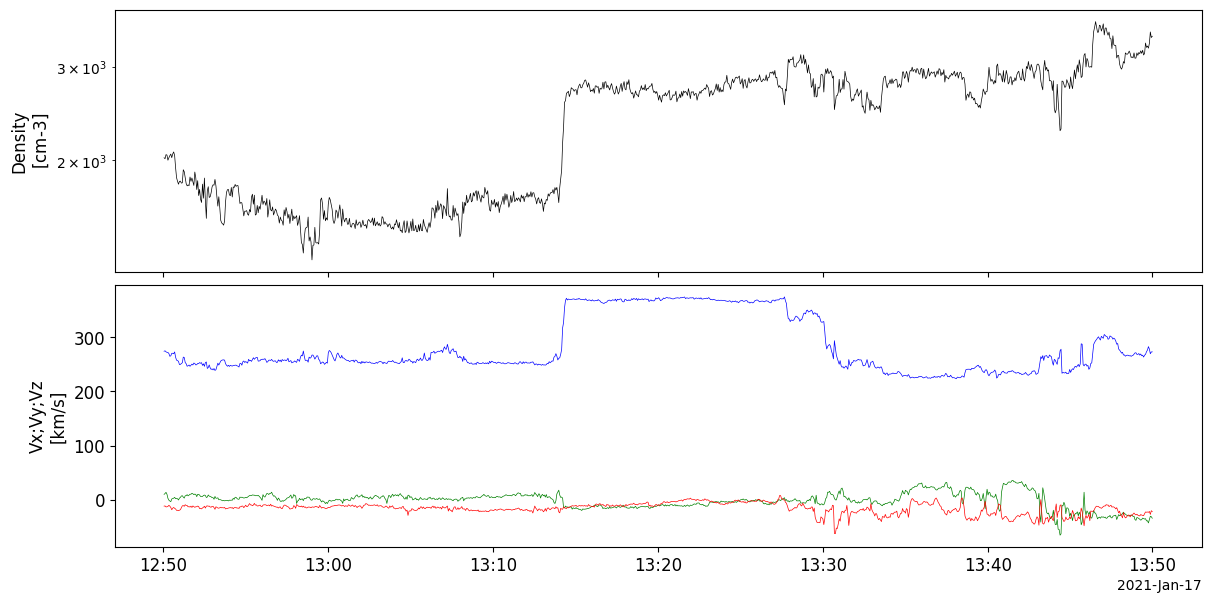

In [33]:
# PSP Event 7
Event_number = 7
starttime = "2021-1-17/12:50"
endtime = "2021-1-17/13:50"

fields_vars = pyspedas.psp.fields(trange=[starttime, endtime], datatype='mag_rtn', level='l2', time_clip=True)
tplot('psp_fld_l2_mag_RTN')
fields_datetime = pyspedas.time_datetime(get_data('psp_fld_l2_mag_RTN').times)
Br, Bt, Bn = get_data('psp_fld_l2_mag_RTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

spi_vars = pyspedas.psp.spi(trange=[starttime, endtime], datatype='sf00_l3_mom', level='l3', time_clip=True)
tplot(['psp_spi_DENS', 'psp_spi_VEL_RTN_SUN'])
nproton_datetime = pyspedas.time_datetime(get_data('psp_spi_DENS').times)
nproton = get_data('psp_spi_DENS').y
vproton_datetime = pyspedas.time_datetime(get_data('psp_spi_VEL_RTN_SUN').times)
vr, vt, vn = get_data('psp_spi_VEL_RTN_SUN').y.T

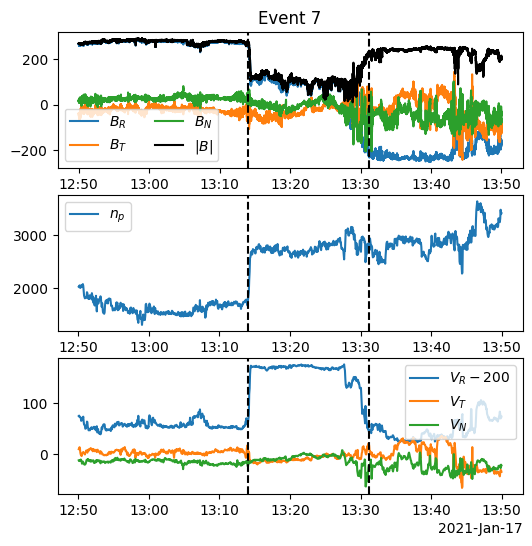

In [34]:
# HCS boundary times
B1_datetime = datetime.datetime(2021, 1, 17, 13, 14, 5)
B2_datetime = datetime.datetime(2021, 1, 17, 13, 31, 15)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-200, label=r'$V_R-200$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [35]:
# Estimate two-sided upstream averages with 15-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=15)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=15)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_fld_l2_mag_RTN_pre')
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_post1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_post')

Br1, Bt1, Bn1 = get_data('psp_fld_l2_mag_RTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('psp_fld_l2_mag_RTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.mean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('psp_spi_DENS', dtime_pre1, dtime_pre2,
                   newname='psp_spi_DENS_pre')
pyspedas.time_clip('psp_spi_DENS', dtime_post1, dtime_post2,
                   newname='psp_spi_DENS_post')
npro1 = get_data('psp_spi_DENS_pre').y
npro2 = get_data('psp_spi_DENS_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('psp_spi_VEL_RTN_SUN', dtime_pre1, dtime_pre2,
                   newname='psp_spi_VEL_RTN_SUN_pre')
pyspedas.time_clip('psp_spi_VEL_RTN_SUN', dtime_post1, dtime_post2,
                   newname='psp_spi_VEL_RTN_SUN_post')

Vr1, Vt1, Vn1 = get_data('psp_spi_VEL_RTN_SUN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('psp_spi_VEL_RTN_SUN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  276.34988 238.31082
n_proton (/cc):  1602.7617 2811.2346
V_r (km/s):  257.7264 239.28992
|V| (km/s):  258.30066 241.71649


In [36]:
# find lmn coordinates with MVA
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_mva')
Br_m, Bt_m, Bn_m = get_data('psp_fld_l2_mag_RTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)

vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

# Thickness with estimated SC frame velocity
pyspedas.time_clip('psp_spi_SC_VEL_RTN_SUN', dtime_pre2, dtime_post1,
                   newname='psp_spi_SC_VEL_RTN_SUN_inhcs')

Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = get_data('psp_spi_SC_VEL_RTN_SUN_inhcs').y.T
Vn_sc_lmn_crossing = (Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2]).mean()
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

[43062.26921414   789.91252786  1530.95920943] [[-0.98525061  0.15992611  0.0608677 ]
 [ 0.04715251 -0.08819995  0.99498613]
 [-0.16449279 -0.98318076 -0.07935814]]
[[-0.98793962  0.03450121 -0.15094695]
 [-0.07701373  0.73623586  0.67232853]
 [ 0.13432871  0.67584497 -0.7246995 ]] 170.37853609121282
Vn (km/s): -8.9; width (km): -9135.9
Vn (km/s): 88.9; width (km): 91558.7


Text(0, 0.5, 'km/s')

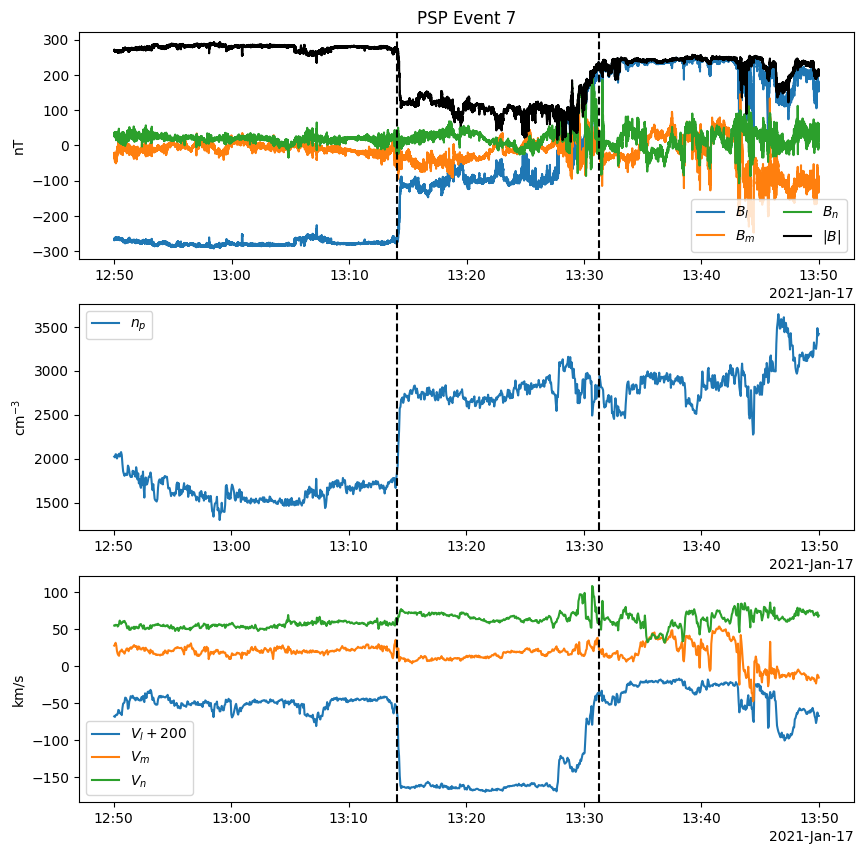

In [37]:
# plot in lmn coordinates, use MVA for this event
Bl_lmn = Br*vecl0[0] + Bt*vecl0[1] + Bn*vecl0[2]
Bm_lmn = Br*vecm0[0] + Bt*vecm0[1] + Bn*vecm0[2]
Bn_lmn = Br*vecn0[0] + Bt*vecn0[1] + Bn*vecn0[2]
vl_lmn = vr*vecl0[0] + vt*vecl0[1] + vn*vecl0[2]
vm_lmn = vr*vecm0[0] + vt*vecm0[1] + vn*vecm0[2]
vn_lmn = vr*vecn0[0] + vt*vecn0[1] + vn*vecn0[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("PSP Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vl_lmn+200, label=r'$V_l+200$')
axs[2].plot(nproton_datetime, vm_lmn, label=r'$V_m$')
axs[2].plot(nproton_datetime, vn_lmn, label=r'$V_n$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

axs[0].set_ylabel("nT")
axs[1].set_ylabel(r"cm$^{-3}$")
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/P%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')

02-Sep-25 15:01:58: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2021/
02-Sep-25 15:01:58: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2021/psp_fld_l2_mag_rtn_2021042906_v02.cdf to psp_data/fields/l2/mag_rtn/2021/psp_fld_l2_mag_rtn_2021042906_v02.cdf
02-Sep-25 15:02:27: Download complete: psp_data/fields/l2/mag_rtn/2021/psp_fld_l2_mag_rtn_2021042906_v02.cdf
02-Sep-25 15:02:30: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2021/
02-Sep-25 15:02:30: File is current: psp_data/fields/l2/mag_rtn/2021/psp_fld_l2_mag_rtn_2021042906_v02.cdf


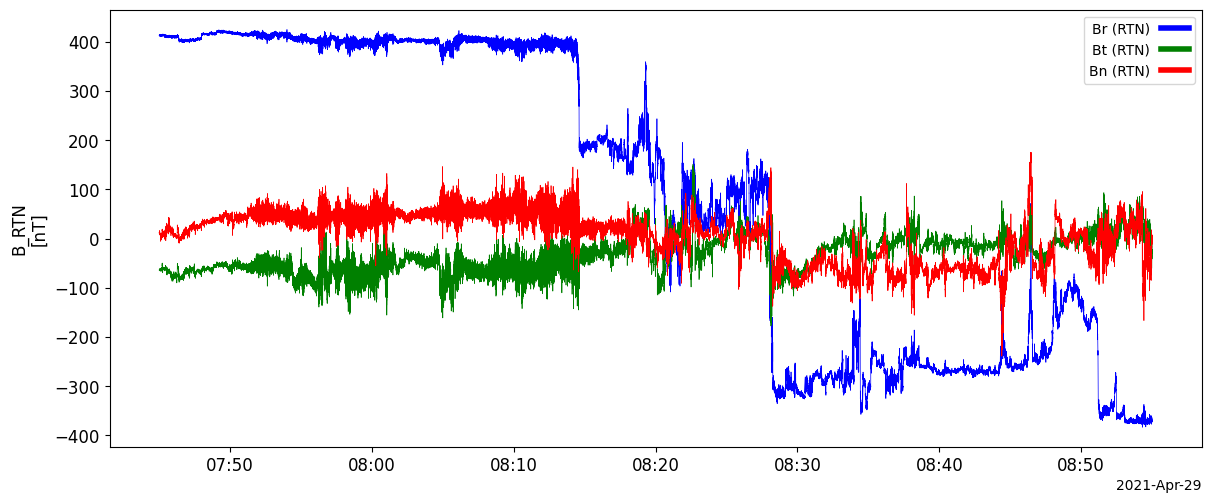

02-Sep-25 15:02:31: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2021/
02-Sep-25 15:02:31: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2021/psp_swp_spi_sf00_l3_mom_20210429_v04.cdf to psp_data/sweap/spi/l3/spi_sf00_l3_mom/2021/psp_swp_spi_sf00_l3_mom_20210429_v04.cdf


Using LEVEL=L3


02-Sep-25 15:02:35: Download complete: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2021/psp_swp_spi_sf00_l3_mom_20210429_v04.cdf


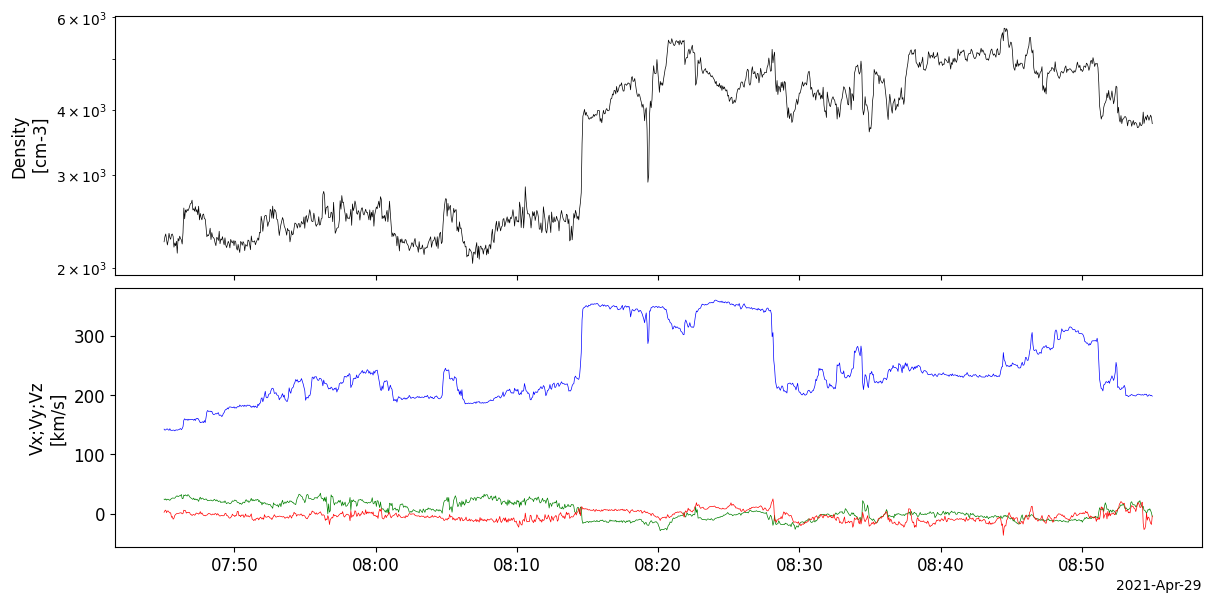

In [38]:
# PSP Event 8
Event_number = 8
starttime = "2021-4-29/7:45"
endtime = "2021-4-29/8:55"

fields_vars = pyspedas.psp.fields(trange=[starttime, endtime], datatype='mag_rtn', level='l2', time_clip=True)
tplot('psp_fld_l2_mag_RTN')
fields_datetime = pyspedas.time_datetime(get_data('psp_fld_l2_mag_RTN').times)
Br, Bt, Bn = get_data('psp_fld_l2_mag_RTN').y.T
BB = Br**2 + Bt**2 + Bn**2
Bmag = np.sqrt(BB)

spi_vars = pyspedas.psp.spi(trange=[starttime, endtime], datatype='sf00_l3_mom', level='l3', time_clip=True)
tplot(['psp_spi_DENS', 'psp_spi_VEL_RTN_SUN'])
nproton_datetime = pyspedas.time_datetime(get_data('psp_spi_DENS').times)
nproton = get_data('psp_spi_DENS').y
vproton_datetime = pyspedas.time_datetime(get_data('psp_spi_VEL_RTN_SUN').times)
vr, vt, vn = get_data('psp_spi_VEL_RTN_SUN').y.T

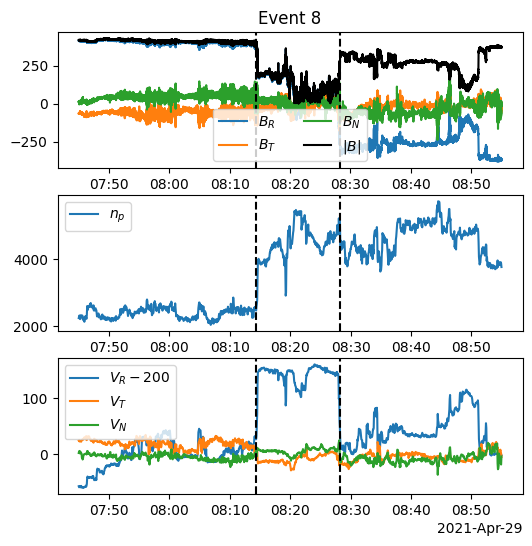

In [39]:
# HCS boundary times
B1_datetime = datetime.datetime(2021, 4, 29, 8, 14, 23)
B2_datetime = datetime.datetime(2021, 4, 29, 8, 28, 16)

fig, axs = plt.subplots(3,1,figsize=(6,6))
axs[0].plot(fields_datetime, Br, label=r'$B_R$')
axs[0].plot(fields_datetime, Bt, label=r'$B_T$')
axs[0].plot(fields_datetime, Bn, label=r'$B_N$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2)
axs[0].set_title("Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend()
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vr-200, label=r'$V_R-200$')
axs[2].plot(nproton_datetime, vt, label=r'$V_T$')
axs[2].plot(nproton_datetime, vn, label=r'$V_N$')
axs[2].legend()
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

In [40]:
# Estimate two-sided upstream averages with 5-minute intervals
B1p_datetime = B1_datetime - datetime.timedelta(minutes=5)
B2a_datetime = B2_datetime + datetime.timedelta(minutes=5)

dtime_pre1 = pyspedas.time_double(str(B1p_datetime))
dtime_pre2 = pyspedas.time_double(str(B1_datetime))
dtime_post1 = pyspedas.time_double(str(B2_datetime))
dtime_post2 = pyspedas.time_double(str(B2a_datetime))

pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_pre2,
                   newname='psp_fld_l2_mag_RTN_pre')
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_post1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_post')

Br1, Bt1, Bn1 = get_data('psp_fld_l2_mag_RTN_pre').y.T
BB1 = Br1**2 + Bt1**2 + Bn1**2
Bmag1 = np.sqrt(BB1)
Bmag_av1 = np.nanmean(Bmag1)

Br2, Bt2, Bn2 = get_data('psp_fld_l2_mag_RTN_post').y.T
BB2 = Br2**2 + Bt2**2 + Bn2**2
Bmag2 = np.sqrt(BB2)
Bmag_av2 = np.mean(Bmag2)

print('|B| (nT): ', Bmag_av1, Bmag_av2)

pyspedas.time_clip('psp_spi_DENS', dtime_pre1, dtime_pre2,
                   newname='psp_spi_DENS_pre')
pyspedas.time_clip('psp_spi_DENS', dtime_post1, dtime_post2,
                   newname='psp_spi_DENS_post')
npro1 = get_data('psp_spi_DENS_pre').y
npro2 = get_data('psp_spi_DENS_post').y
npro_av1 = np.nanmean(npro1)
npro_av2 = np.nanmean(npro2)

print('n_proton (/cc): ', npro_av1, npro_av2)

pyspedas.time_clip('psp_spi_VEL_RTN_SUN', dtime_pre1, dtime_pre2,
                   newname='psp_spi_VEL_RTN_SUN_pre')
pyspedas.time_clip('psp_spi_VEL_RTN_SUN', dtime_post1, dtime_post2,
                   newname='psp_spi_VEL_RTN_SUN_post')

Vr1, Vt1, Vn1 = get_data('psp_spi_VEL_RTN_SUN_pre').y.T
Vmag1 = np.sqrt(Vr1**2 + Vt1**2 + Vn1**2)
Vr_av1 = np.nanmean(Vr1)
Vmag_av1 = np.nanmean(Vmag1)

Vr2, Vt2, Vn2 = get_data('psp_spi_VEL_RTN_SUN_post').y.T
Vmag2 = np.sqrt(Vr2**2 + Vt2**2 + Vn2**2)
Vr_av2 = np.nanmean(Vr2)
Vmag_av2 = np.nanmean(Vmag2)

print('V_r (km/s): ', Vr_av1, Vr_av2)
print('|V| (km/s): ', Vmag_av1, Vmag_av2)

|B| (nT):  402.28458 307.1615
n_proton (/cc):  2478.553 4245.428
V_r (km/s):  211.4495 219.0295
|V| (km/s):  212.50554 219.6734


In [41]:
# find lmn coordinates with MVA
pyspedas.time_clip('psp_fld_l2_mag_RTN', dtime_pre1, dtime_post2,
                   newname='psp_fld_l2_mag_RTN_mva')
Br_m, Bt_m, Bn_m = get_data('psp_fld_l2_mag_RTN_mva').y.T
vecl0, vecm0, vecn0 = mva_ts(Br_m, Bt_m, Bn_m)

vnc, th12 = vnormc(np.array([np.nanmean(Br1), np.nanmean(Bt1), np.nanmean(Bn1)]),
                   np.array([np.nanmean(Br2), np.nanmean(Bt2), np.nanmean(Bn2)]))
vecl, vecm, vecn = hyb_lmn(vecl0, vecm0, vecn0, vnc)
print(np.array([vecl, vecm, vecn]), th12)

# Thickness with estimated SC frame velocity
pyspedas.time_clip('psp_spi_SC_VEL_RTN_SUN', dtime_pre2, dtime_post1,
                   newname='psp_spi_SC_VEL_RTN_SUN_inhcs')

Vr_sc_hcs, Vt_sc_hcs, Vn_sc_hcs = get_data('psp_spi_SC_VEL_RTN_SUN_inhcs').y.T
Vn_sc_lmn_crossing = (Vr_sc_hcs*vecn0[0] + Vt_sc_hcs*vecn0[1] + Vn_sc_hcs*vecn0[2]).mean()
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

# use cross product normal
Vn_sc_lmn_crossing = np.nanmean(Vr_sc_hcs*vnc[0] + Vt_sc_hcs*vnc[1] + Vn_sc_hcs*vnc[2])
width_hcs = Vn_sc_lmn_crossing * (B2_datetime - B1_datetime)/datetime.timedelta(seconds=1)
print("Vn (km/s): %.1f; width (km): %.1f" %(Vn_sc_lmn_crossing, width_hcs))

[56700.79067521   495.80786717  1379.47954911] [[ 0.98679454  0.16170454  0.00939011]
 [ 0.00626664  0.01981515 -0.99978402]
 [ 0.16185568 -0.98664026 -0.01854013]]
[[ 0.98546393  0.00446289  0.16982619]
 [ 0.04129357 -0.97596707 -0.21396989]
 [ 0.16478983  0.21787232 -0.96196455]] 162.30146856745756
Vn (km/s): 6.6; width (km): 5503.7
Vn (km/s): 35.7; width (km): 29773.3


Text(0, 0.5, 'km/s')

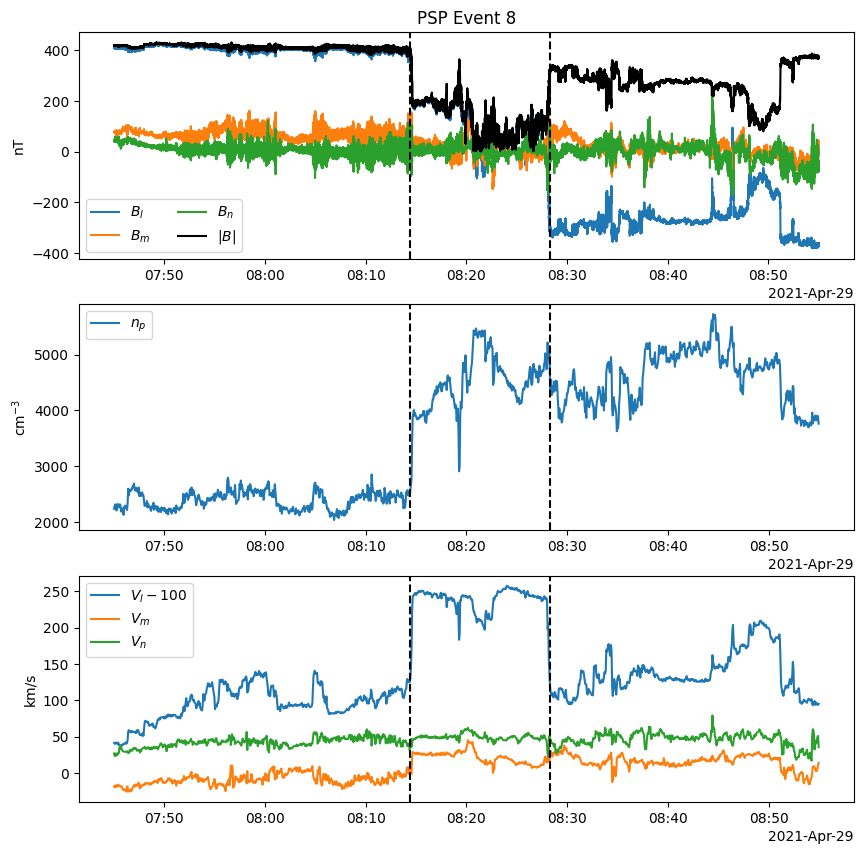

In [42]:
# plot in hybrid lmn coordinates
Bl_lmn = Br*vecl[0] + Bt*vecl[1] + Bn*vecl[2]
Bm_lmn = Br*vecm[0] + Bt*vecm[1] + Bn*vecm[2]
Bn_lmn = Br*vecn[0] + Bt*vecn[1] + Bn*vecn[2]
vl_lmn = vr*vecl[0] + vt*vecl[1] + vn*vecl[2]
vm_lmn = vr*vecm[0] + vt*vecm[1] + vn*vecm[2]
vn_lmn = vr*vecn[0] + vt*vecn[1] + vn*vecn[2]

fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(fields_datetime, Bl_lmn, label=r'$B_l$')
axs[0].plot(fields_datetime, Bm_lmn, label=r'$B_m$')
axs[0].plot(fields_datetime, Bn_lmn, label=r'$B_n$')
axs[0].plot(fields_datetime, Bmag, label=r'$|B|$', color='k')
axs[0].legend(ncol=2, loc='lower left')
axs[0].set_title("PSP Event %d" %(Event_number))
axs[0].axvline(B1_datetime, color='k', ls='--')
axs[0].axvline(B2_datetime, color='k', ls='--')

axs[1].plot(nproton_datetime, nproton, label=r'$n_p$')
axs[1].legend(loc='upper left')
axs[1].axvline(B1_datetime, color='k', ls='--')
axs[1].axvline(B2_datetime, color='k', ls='--')

axs[2].plot(nproton_datetime, vl_lmn-100, label=r'$V_l-100$')
axs[2].plot(nproton_datetime, vm_lmn, label=r'$V_m$')
axs[2].plot(nproton_datetime, vn_lmn, label=r'$V_n$')
axs[2].legend(loc='upper left')
axs[2].axvline(B1_datetime, color='k', ls='--')
axs[2].axvline(B2_datetime, color='k', ls='--')

axs[0].set_ylabel("nT")
axs[1].set_ylabel(r"cm$^{-3}$")
axs[2].set_ylabel('km/s')
# plt.savefig("./Event_figures/P%d_lmn.png" %Event_number, dpi=300, bbox_inches='tight')